# Preprocessing

In [16]:
# Data processing of the questionnaire
# https://forms.gle/TiY3p9WSkGV8mNKk6

# importing packages
import pandas as pd
#from SPARQLWrapper import SPARQLWrapper, JSON
#import lxml
import os.path, time


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json

#inNotebook = True # change this to True if you use a notebook
#def nextplot():
#    if inNotebook:
#        plt.figure()  # this creates a new plot
#    else:
#        plt.clf()     # and this clears the current one

!python --version
print('------------')
print("Pandas " + pd.__version__)
print("Numpy " + np.__version__)
print("Seaborn " + sns.__version__)

Python 3.7.6
------------
Pandas 1.3.4
Numpy 1.18.1
Seaborn 0.11.2


In [2]:
# load survey .csv-file
df = pd.read_csv('../data/Survey_data_processed.csv', sep=';')

# print last modification date of the survey file
print("Source file last modified: %s" % time.ctime(os.path.getmtime('../data/Survey_data_processed.csv')))
df.head()

Source file last modified: Tue Apr 19 12:40:13 2022


,Zeitstempel,Name up to three movies from the 90s,Name up to three actors,Name up to three music genres,Name up to three books,Name up to three (book) authors,Name up to three politicians,Name up to three US presidents,Name up to three cities,Name up to three lakes,...,Name up to three vegetables,Name up to three types of fast food,Name up to three landmarks/sights in Europe,Name up to three companies listed in the DAX (German stock index),Name up to three US companies,Name up to three US tech companies,What is your age?,What gender do you identify with?,What is the highest degree you have completed?,Which country are you from?
0,2022/02/28 5:09:27 PM OEZ,"The Matrix, Groundhog Day, Goodfellas","Tom Cruise, Amy Adams, Arnold Schwarzenegger","Pop, Techno, Rap","Dune, How Democracies Die, Harry Potter","Frank Herbert, George R. R. Martin, J. K. Rowl...","Barack Obama, Olaf Scholz, Robert Habeck","Barack Obama, Joe Biden, George Washington","Berlin, New York, Moskau","Bodensee, Lake Victoria, Lake Tahoe",...,"Peas, Carrot, Tomato","Fries, Burger, Pizza","Eiffel tower, Brandenburger Gate, Colosseum","SAP, Allianz, Lufthansa","Microsoft, T-Mobile, Ralph Lauren","Apple, Google, Tesla",26.0,Male,Bachelor's degree,Germany
1,2022/03/01 5:03:02 PM OEZ,"Batman, Matrix, Eyes Wide Shut","Jack Nicholson, Nicole Kidman, George Clooney","Metal, Rock, Pop","Hamlet, Faust, Werther","Shakespeare, Goethe, Stephen King","Angela Merkel, Joe Biden, George W. Bush","Joe Biden, Goerge W. Bush, Barack Obama","New York, Amsterdam, Berlin","Lake Geneva, Lake Tahoe, Lake Eerie",...,"Cucumber, Tomato, Zucchini","Burger, Pizza, Fries","Eiffel Tower, Tower Bridge, Tower of Pisa","SAP, BMW, Siemens","Ford, General Electric, Meta","Meta, Alphabet, Zoom",44.0,Male,Doctorate (e.g. PhD),Germany
2,2022/03/01 5:34:10 PM OEZ,"Total Recall, Lethal Weapon, Predator","Gérard Depardieu, Christina Ricci, Brad Pitt","Funk, Rock, Electro","Hyperion, Harry Potter, Game of Thrones","Asimov, Frank Herbert, Simmons","Jean-Luc Mélenchon, Raphaël Correa, Gabriel Boric","George Washington, Abraham Lincoln, Richard Nixon","Paris, New York, Istanbul","Erie, Léman",...,"Leek, Cabbage, Potato","Burger, Poutine, Hotdog","Eiffel Tower, Tower of Pisa, Stonehenge","Bayer, BMW, Volkswagen","General Motors, General Electric, McDonalds","Google, Amazon, Microsoft",46.0,Male,Bachelor's degree,France
3,2022/03/01 6:25:03 PM OEZ,"Léon: The Professional, The Matrix, Departed","Brad Pitt, Denzel Washington, George Clooney","Techno, House, Jazz","Illuminati, Das Kapital, The Prisoner","J. K. Rowling, John Grisham, Dan Brown","Robert Habeck, Olaf Scholz, Martin Schulz","Donald Trump, John F. Kennedy, Gerald Ford","Berlin, New York, Kyiv","Gardasee, Lake Michigan, Bodensee",...,"Zucchini, Aubergine, Pepper","Burger, Fries, Pizza","Eiffeltower, Brandenburg Gate, London Eye","Lufthansa, Volkswagen, Fresenius","Apple, Alphabet, Tesla Motors","Alphabet, Apple, Oracle",28.0,Male,Master's degree,Germany
4,2022/03/01 6:31:24 PM OEZ,"Home Alone, matrix, titanic","Nicole Kidman, Meryl Streep, Penelope Cruz","Jazz, pop, hip-hop","Idiot, Noisy Bear, Being and Time","Dostoevsky, Nabokov, Bradbury","Merkel, Obama, Biden","Obama, Biden, Lincoln","Leuven, Chisinau, Moscow","Geneva lake Baikal lake, Lugano Lake",...,"Bell pepper, aubergine, tomato","Fries, burger, nuggets","Eiffel Tower, Big Ben, Maneken Piss","Zalando, Volkswagen, Daimler","Walmart, Amazon, Apple","Tesla, Google, Microsoft",34.0,Female,Master's degree,Switzerland


In [3]:
# Print submitted answers and calculate the approx. amount of answers after splitting
print("Answers submitted: " + str(len(df.index)))
print("Answers processed(approx.): " + str(len(df.index)*3))

Answers submitted: 109
Answers processed(approx.): 327


In [4]:
# dictionary for renaming column names
# key = old name : value = new name

dict_col_names = {'Zeitstempel':'timestamp',
        'Name up to three movies from the 90s': 'nineties_movies',
        'Name up to three actors': 'actors',
        'Name up to three music genres': 'music_genres',
        'Name up to three books':'books',
        'Name up to three (book) authors':'authors', #or book_authors?
        'Name up to three politicians':'politicians',
        'Name up to three US presidents':'us_presidents',
        'Name up to three cities':'cities',
        'Name up to three lakes':'lakes',
        'Name up to three mountains':'mountains',
        'Name up to three european capital cities':'european_capital_cities',
        'Name up to three european countries':'european_countries',
        'Name up to three asian countries':'asian_countries',
        'Name up to three continents':'continents',
        'Name up to three birds':'birds',
        'Name up to three african animals':'african_animals',
        'Name up to three pieces of furniture':'furniture',
        'Name up to three vegetables':'vegetables',
        'Name up to three types of fast food':'fast_food',
        'Name up to three landmarks/sights in Europe':'european_landmarks',
        'Name up to three companies listed in the DAX (German stock index)':'dax_companies',
        'Name up to three US companies':'us_companies',
        'Name up to three US tech companies':'us_tech_companies',
        'What is your age?':'p_age', # p for participant, partaker, player
        'What gender do you identify with?':'p_gender',
        'What is the highest degree you have completed?':'p_education',
        'Which country are you from?':'p_country'
}

df.rename(columns=dict_col_names, inplace=True)
df.head()

,timestamp,nineties_movies,actors,music_genres,books,authors,politicians,us_presidents,cities,lakes,...,vegetables,fast_food,european_landmarks,dax_companies,us_companies,us_tech_companies,p_age,p_gender,p_education,p_country
0,2022/02/28 5:09:27 PM OEZ,"The Matrix, Groundhog Day, Goodfellas","Tom Cruise, Amy Adams, Arnold Schwarzenegger","Pop, Techno, Rap","Dune, How Democracies Die, Harry Potter","Frank Herbert, George R. R. Martin, J. K. Rowl...","Barack Obama, Olaf Scholz, Robert Habeck","Barack Obama, Joe Biden, George Washington","Berlin, New York, Moskau","Bodensee, Lake Victoria, Lake Tahoe",...,"Peas, Carrot, Tomato","Fries, Burger, Pizza","Eiffel tower, Brandenburger Gate, Colosseum","SAP, Allianz, Lufthansa","Microsoft, T-Mobile, Ralph Lauren","Apple, Google, Tesla",26.0,Male,Bachelor's degree,Germany
1,2022/03/01 5:03:02 PM OEZ,"Batman, Matrix, Eyes Wide Shut","Jack Nicholson, Nicole Kidman, George Clooney","Metal, Rock, Pop","Hamlet, Faust, Werther","Shakespeare, Goethe, Stephen King","Angela Merkel, Joe Biden, George W. Bush","Joe Biden, Goerge W. Bush, Barack Obama","New York, Amsterdam, Berlin","Lake Geneva, Lake Tahoe, Lake Eerie",...,"Cucumber, Tomato, Zucchini","Burger, Pizza, Fries","Eiffel Tower, Tower Bridge, Tower of Pisa","SAP, BMW, Siemens","Ford, General Electric, Meta","Meta, Alphabet, Zoom",44.0,Male,Doctorate (e.g. PhD),Germany
2,2022/03/01 5:34:10 PM OEZ,"Total Recall, Lethal Weapon, Predator","Gérard Depardieu, Christina Ricci, Brad Pitt","Funk, Rock, Electro","Hyperion, Harry Potter, Game of Thrones","Asimov, Frank Herbert, Simmons","Jean-Luc Mélenchon, Raphaël Correa, Gabriel Boric","George Washington, Abraham Lincoln, Richard Nixon","Paris, New York, Istanbul","Erie, Léman",...,"Leek, Cabbage, Potato","Burger, Poutine, Hotdog","Eiffel Tower, Tower of Pisa, Stonehenge","Bayer, BMW, Volkswagen","General Motors, General Electric, McDonalds","Google, Amazon, Microsoft",46.0,Male,Bachelor's degree,France
3,2022/03/01 6:25:03 PM OEZ,"Léon: The Professional, The Matrix, Departed","Brad Pitt, Denzel Washington, George Clooney","Techno, House, Jazz","Illuminati, Das Kapital, The Prisoner","J. K. Rowling, John Grisham, Dan Brown","Robert Habeck, Olaf Scholz, Martin Schulz","Donald Trump, John F. Kennedy, Gerald Ford","Berlin, New York, Kyiv","Gardasee, Lake Michigan, Bodensee",...,"Zucchini, Aubergine, Pepper","Burger, Fries, Pizza","Eiffeltower, Brandenburg Gate, London Eye","Lufthansa, Volkswagen, Fresenius","Apple, Alphabet, Tesla Motors","Alphabet, Apple, Oracle",28.0,Male,Master's degree,Germany
4,2022/03/01 6:31:24 PM OEZ,"Home Alone, matrix, titanic","Nicole Kidman, Meryl Streep, Penelope Cruz","Jazz, pop, hip-hop","Idiot, Noisy Bear, Being and Time","Dostoevsky, Nabokov, Bradbury","Merkel, Obama, Biden","Obama, Biden, Lincoln","Leuven, Chisinau, Moscow","Geneva lake Baikal lake, Lugano Lake",...,"Bell pepper, aubergine, tomato","Fries, burger, nuggets","Eiffel Tower, Big Ben, Maneken Piss","Zalando, Volkswagen, Daimler","Walmart, Amazon, Apple","Tesla, Google, Microsoft",34.0,Female,Master's degree,Switzerland


In [5]:
dfLatex = df.head(5)
dfLatex.to_latex()

"\\begin{tabular}{lllllllllllllllllllllllllrlll}\n\\toprule\n{} &                  timestamp &                                nineties\\_movies &                                         actors &         music\\_genres &                                    books &                                            authors &                                        politicians &                                      us\\_presidents &                       cities &                                 lakes &                                mountains &  european\\_capital\\_cities &         european\\_countries &            asian\\_countries &                   continents &                          birds &              african\\_animals &               furniture &                      vegetables &                fast\\_food &                           european\\_landmarks &                     dax\\_companies &                                 us\\_companies &          us\\_tech\\_companies &  p\\_age & p\\

In [6]:
# print answers per category (pre splitting)
df_answers = df.count()
df_answers
#df_answers_mean = df_answers.mean()
#int(df_answers_mean)

timestamp                  109
nineties_movies             96
actors                     107
music_genres               109
books                      104
authors                    103
politicians                109
us_presidents              108
cities                     109
lakes                      107
mountains                  109
european_capital_cities    109
european_countries         109
asian_countries            108
continents                 109
birds                      104
african_animals            109
furniture                  109
vegetables                 108
fast_food                  109
european_landmarks         106
dax_companies               99
us_companies               109
us_tech_companies          108
p_age                      108
p_gender                   109
p_education                107
p_country                  107
dtype: int64

In [7]:
# add ID column based on index
p_id = df.index
df['p_id'] = p_id
#df.insert(0, 'pp_id', 'p' + df.index.astype(str))


# Replace missing/NaN values for participants age with 0 and convert from float64 to int64
df.p_age = pd.to_numeric(df.p_age, errors='coerce').fillna(0, downcast='infer') #downcast=infer handles the change from float to int

# Replace NaN float values with String for the remaining columns
df = df.fillna('NaN')

# Clean and unify participants origin country and education data
#df.p_country = df.p_country.astype(str)
df.p_country = df.p_country.str.lower()
df['p_country'] = df['p_country'].replace('united states of america','usa', regex=True).replace('deutschland','germany', regex=True).replace(' ','', regex=True).replace('\.','', regex=True)
df.p_country = df.p_country.str.capitalize()
df['p_country'] = df['p_country'].replace('Nan','NaN', regex=True).replace('Usa','USA', regex=True)
df['p_education'] = df['p_education'].replace('Diplom', 'Master\'s degree', regex=True).replace('Dipl.-Ing.', 'Master\'s degree', regex=True)
df
#df.dtypes

,timestamp,nineties_movies,actors,music_genres,books,authors,politicians,us_presidents,cities,lakes,...,fast_food,european_landmarks,dax_companies,us_companies,us_tech_companies,p_age,p_gender,p_education,p_country,p_id
0,2022/02/28 5:09:27 PM OEZ,"The Matrix, Groundhog Day, Goodfellas","Tom Cruise, Amy Adams, Arnold Schwarzenegger","Pop, Techno, Rap","Dune, How Democracies Die, Harry Potter","Frank Herbert, George R. R. Martin, J. K. Rowl...","Barack Obama, Olaf Scholz, Robert Habeck","Barack Obama, Joe Biden, George Washington","Berlin, New York, Moskau","Bodensee, Lake Victoria, Lake Tahoe",...,"Fries, Burger, Pizza","Eiffel tower, Brandenburger Gate, Colosseum","SAP, Allianz, Lufthansa","Microsoft, T-Mobile, Ralph Lauren","Apple, Google, Tesla",26,Male,Bachelor's degree,Germany,0
1,2022/03/01 5:03:02 PM OEZ,"Batman, Matrix, Eyes Wide Shut","Jack Nicholson, Nicole Kidman, George Clooney","Metal, Rock, Pop","Hamlet, Faust, Werther","Shakespeare, Goethe, Stephen King","Angela Merkel, Joe Biden, George W. Bush","Joe Biden, Goerge W. Bush, Barack Obama","New York, Amsterdam, Berlin","Lake Geneva, Lake Tahoe, Lake Eerie",...,"Burger, Pizza, Fries","Eiffel Tower, Tower Bridge, Tower of Pisa","SAP, BMW, Siemens","Ford, General Electric, Meta","Meta, Alphabet, Zoom",44,Male,Doctorate (e.g. PhD),Germany,1
2,2022/03/01 5:34:10 PM OEZ,"Total Recall, Lethal Weapon, Predator","Gérard Depardieu, Christina Ricci, Brad Pitt","Funk, Rock, Electro","Hyperion, Harry Potter, Game of Thrones","Asimov, Frank Herbert, Simmons","Jean-Luc Mélenchon, Raphaël Correa, Gabriel Boric","George Washington, Abraham Lincoln, Richard Nixon","Paris, New York, Istanbul","Erie, Léman",...,"Burger, Poutine, Hotdog","Eiffel Tower, Tower of Pisa, Stonehenge","Bayer, BMW, Volkswagen","General Motors, General Electric, McDonalds","Google, Amazon, Microsoft",46,Male,Bachelor's degree,France,2
3,2022/03/01 6:25:03 PM OEZ,"Léon: The Professional, The Matrix, Departed","Brad Pitt, Denzel Washington, George Clooney","Techno, House, Jazz","Illuminati, Das Kapital, The Prisoner","J. K. Rowling, John Grisham, Dan Brown","Robert Habeck, Olaf Scholz, Martin Schulz","Donald Trump, John F. Kennedy, Gerald Ford","Berlin, New York, Kyiv","Gardasee, Lake Michigan, Bodensee",...,"Burger, Fries, Pizza","Eiffeltower, Brandenburg Gate, London Eye","Lufthansa, Volkswagen, Fresenius","Apple, Alphabet, Tesla Motors","Alphabet, Apple, Oracle",28,Male,Master's degree,Germany,3
4,2022/03/01 6:31:24 PM OEZ,"Home Alone, matrix, titanic","Nicole Kidman, Meryl Streep, Penelope Cruz","Jazz, pop, hip-hop","Idiot, Noisy Bear, Being and Time","Dostoevsky, Nabokov, Bradbury","Merkel, Obama, Biden","Obama, Biden, Lincoln","Leuven, Chisinau, Moscow","Geneva lake Baikal lake, Lugano Lake",...,"Fries, burger, nuggets","Eiffel Tower, Big Ben, Maneken Piss","Zalando, Volkswagen, Daimler","Walmart, Amazon, Apple","Tesla, Google, Microsoft",34,Female,Master's degree,Switzerland,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,2022/03/24 1:59:30 PM OEZ,"Ghost Dog: The Way of the Samurai, Mrs. Doubtf...","Brad Pitt, Lily James, Paul Dano","Hip hop, Rock, Pop","Milkman, Sarah, The Magic of Thinking Big","Anthony Robbins, Esther Hicks, Jerry Hicks","Bernard Sanders, Angela Merkel, Boris Johnson","Bill Clinton, George W. Bush, Barack Obama","New York, Washington, Dublin","Lake Baikal, Lake Superior, Lake Victoria",...,"Pizza, Burger, Fries","Glendalough, Bray, Kilkenny","Airbus, Adidas, Allianz","Apple, Walmart, Amazon","IBM, Google, Microsoft",33,Female,Master's degree,Iran,104
105,2022/03/24 5:30:21 PM OEZ,NaN,"Richard Gere, Julia Roberts, Bruce Willis","pop, metal, hip hop","Catcher in the rye, Tom Sawyer, The Bible","Stephen King, Ernest Hemingway, Astrid Lindgren","Boris Johnson, Angela Merkel, Madeleine Albright","Roosevelt, Obama, George W. Bush","New York, Stockholm, Munich","Lake Ontario, Lake Victoria, Bodensee",...,"hamburger, fried chicken, pizza","Big Ben

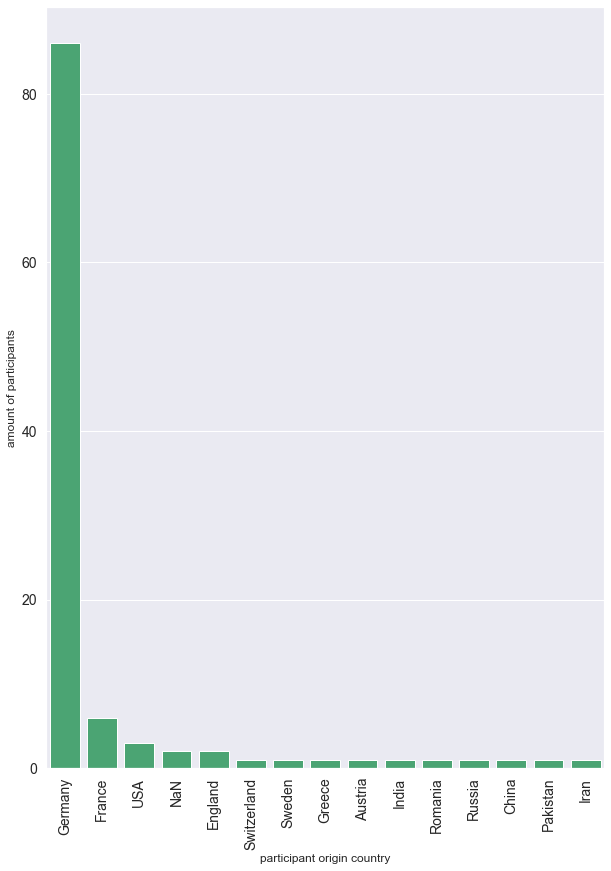

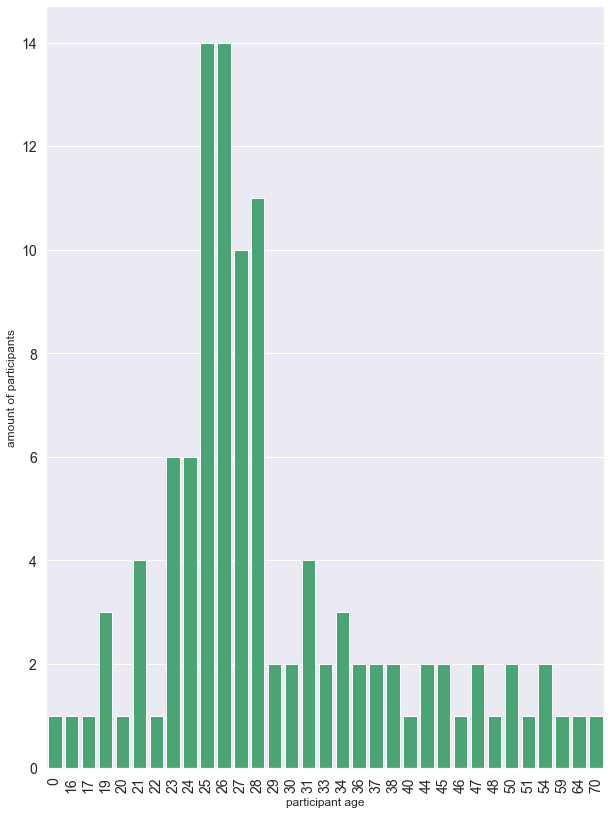

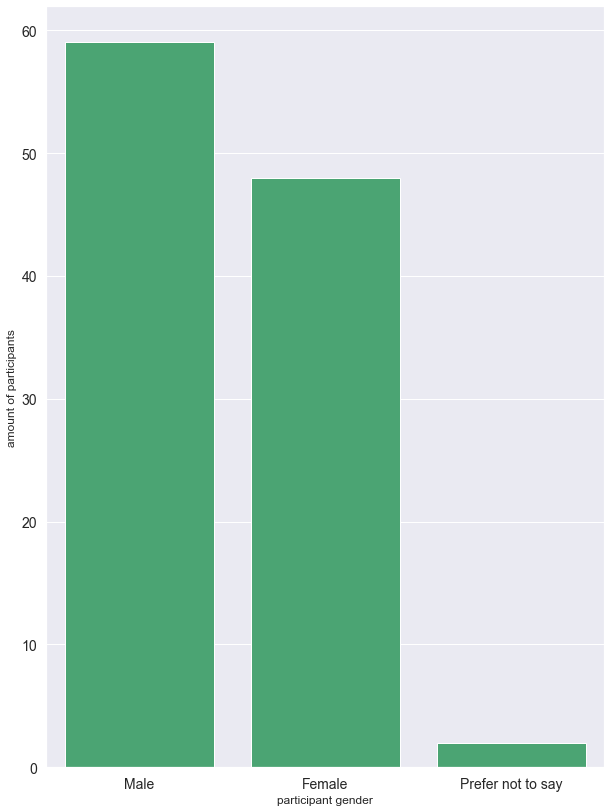

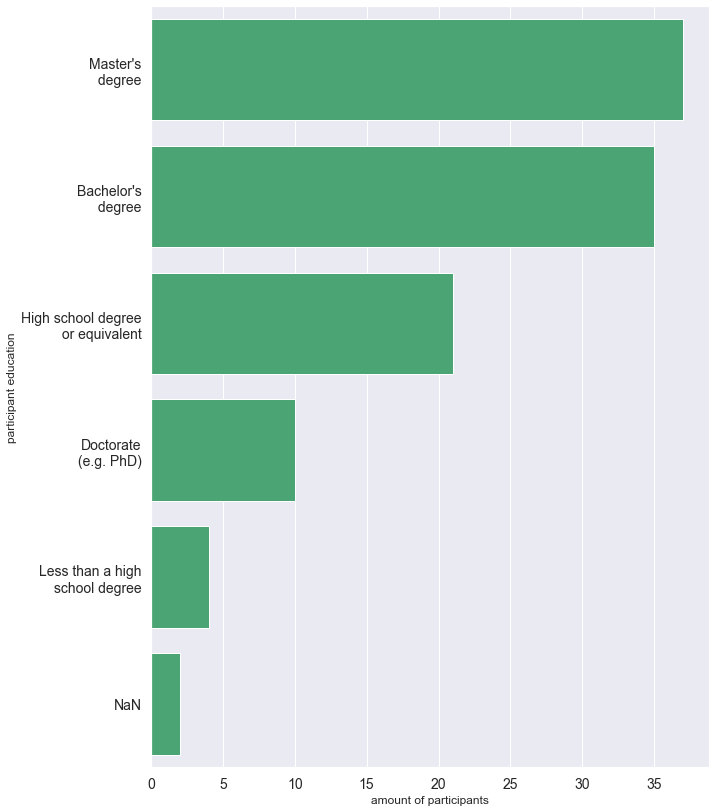

In [52]:
## Plot demographic data

df_plots = df.copy()
df_plots['p_education'] = df_plots['p_education'].replace('Bachelor\'s degree', 'Bachelor\'s\n degree', regex=True).replace('Master\'s degree', 'Master\'s\n degree', regex=True).replace('High school degree or equivalent', 'High school degree\n or equivalent', regex=True).replace('Less than a high school degree', 'Less than a high\n school degree', regex=True).replace('Doctorate \(e.g. PhD\)', 'Doctorate\n (e.g. PhD)', regex=True)


# Plot participant origin country
plt.figure()
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="p_country", data=df_plots, color='mediumseagreen', order = df_plots['p_country'].value_counts().index)
sns.set(rc={'figure.figsize':(10, 14)})
plt.xticks(rotation=90);
#plt.yticks(rotation=90);
plt.tick_params(labelsize=14)
plt.xlabel('participant origin country')
plt.ylabel('amount of participants')

plt.savefig('../plots/participant_origin_country.png', bbox_inches="tight")   # save the figure to file

# Plot participant age
plt.figure()
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="p_age", data=df_plots, color='mediumseagreen')
sns.set(rc={'figure.figsize':(10, 14)})
plt.xticks(rotation=90);
plt.tick_params(labelsize=14)
plt.xlabel('participant age')
plt.ylabel('amount of participants')
#plt.legend(title='Legend', loc='upper right', labels=['NaN = age not specified'])

plt.savefig('../plots/participant_age.png', bbox_inches="tight")   # save the figure to file

# Plot participant gender
plt.figure()
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="p_gender", data=df_plots, color='mediumseagreen', order = df_plots['p_gender'].value_counts().index)
sns.set(rc={'figure.figsize':(10, 14)})
#plt.xticks(rotation=90);
plt.tick_params(labelsize=14)
plt.xlabel('participant gender')
plt.ylabel('amount of participants')

plt.savefig('../plots/participant_gender.png', bbox_inches="tight")   # save the figure to file

# Plot participant education
plt.figure()
sns.set_theme(style="darkgrid")
ax = sns.countplot(y="p_education", data=df_plots, color='mediumseagreen', order = df_plots['p_education'].value_counts().index)
sns.set(rc={'figure.figsize':(10, 14)})
#plt.xticks(rotation=90);
plt.tick_params(labelsize=14)
plt.ylabel('participant education')
plt.xlabel('amount of participants')

plt.savefig('../plots/participant_education.png', bbox_inches="tight")   # save the figure to file

## Cleaning the categories TRY1

In [8]:
# Function that takes a specific column out of the DataFrame, cleans it and returns it as a new DF
# needs DF column as dfColumnName and a string for the new DF column as cName

  # Idea, rewrite function so that the demographic data is kept (sex, age, education, country, ...)
  # --> DONE, see exploder()
  # Rows are split due to multiple answers. How can I avoid the loss of data?
  # https://stackoverflow.com/questions/12680754/split-explode-pandas-dataframe-string-entry-to-separate-rows

def one_column_split(df_column, category_name):
    helper_series = df_column
    helper_series = helper_series.str.lower()
    helper_series = [c.replace(';', ', ') for c in helper_series]
    helper_series = [c.replace('/', ', ') for c in helper_series]
    helper_series = [c.replace('?', ', ') for c in helper_series]
    helper_series = [c.replace("'", " ") for c in helper_series]
    helper_series = [c.replace('-', '') for c in helper_series]
    helper_series = [c.replace(' ', '') for c in helper_series]
    
    helper_series = [x.split(',') for x in helper_series]
    helper_list = [x for y in helper_series for x in y]
    helper_df = pd.DataFrame(helper_list)
    helper_df = helper_df.rename(columns={0: category_name})

    return helper_df

In [9]:
df_nineties_movies = one_column_split(df.nineties_movies, 'nineties_movies')
df_actors = one_column_split(df.actors, 'actors')
df_music_genres = one_column_split(df.music_genres, 'music_genres')
df_books = one_column_split(df.books, 'books')
df_authors = one_column_split(df.authors, 'authors')
df_politicians = one_column_split(df.politicians, 'politicians')
df_us_presidents = one_column_split(df.us_presidents, 'us_presidents')
df_cities = one_column_split(df.cities, 'cities')
df_lakes = one_column_split(df.lakes, 'lakes')
df_mountains = one_column_split(df.mountains, 'mountains')
df_european_capital_cities = one_column_split(df.european_capital_cities, 'european_capital_cities')
df_european_countries = one_column_split(df.european_countries, 'european_countries')
df_asian_countries = one_column_split(df.asian_countries, 'asian_countries')
df_continents = one_column_split(df.continents, 'continents')
df_birds = one_column_split(df.birds, 'birds')
df_african_animals = one_column_split(df.african_animals, 'african_animals')
df_furniture = one_column_split(df.furniture, 'furniture')
df_vegetables = one_column_split(df.vegetables, 'vegetables')
df_fast_food = one_column_split(df.fast_food, 'fast_food')
df_european_landmarks = one_column_split(df.european_landmarks, 'european_landmarks')
df_dax_companies = one_column_split(df.dax_companies, 'dax_companies')
df_us_companies = one_column_split(df.us_companies, 'us_companies')
df_us_tech_companies = one_column_split(df.us_tech_companies, 'us_tech_companies')
#p_age
#p_gender
#p_education
#p_country
            
print(df_nineties_movies)

        nineties_movies
0             thematrix
1          groundhogday
2            goodfellas
3                batman
4                matrix
..                  ...
271              clerks
272                    
273         pulpfiction
274  jamesbondgoldeneye
275         findingnemo

[276 rows x 1 columns]


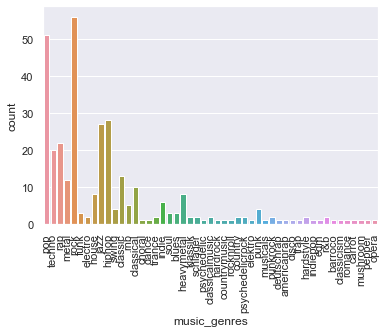

In [10]:
plt.figure()
sns.set_theme(style="darkgrid")
ax = sns.countplot(x='music_genres', data=df_music_genres)
sns.set(rc={'figure.figsize':(10, 14)})
plt.xticks(rotation=90);

In [ ]:
plt.figure()
sns.set_theme(style="darkgrid")
ax = sns.countplot(x='continents', data=df_continents)
sns.set(rc={'figure.figsize':(10, 14)})
plt.xticks(rotation=90);

In [ ]:
# Test: Cut everything after a comma (Here for us_companies)
df_cut_us_companies = df.copy()
df_cut_us_companies['us_companies'] = df_cut_us_companies['us_companies'].str.split(',').str[0]

df_cut_us_companies.head()

In [ ]:
df_continents.head()
#sns.catplot(x="continents", data=df_continents)

## Cleaning the categories TRY2

In [19]:
# Function for splitting(exploding) the comma-separated answers while keeping the demographic data of the survey participant (sex, age, education, country and p_id)

def exploder(data_frame, category_name_string):
    lst_col = category_name_string
    # build helper df consisting of the category + p (participant) columns
    helper_df = data_frame[[lst_col,'p_age','p_gender','p_education','p_country', 'p_id']].copy()
    
    # clean data by lowercasing, removing fault characters and whitespaces
    helper_df[lst_col] = helper_df[lst_col].str.lower()
    helper_df[lst_col] = helper_df[lst_col].replace('\/',',', regex=True).replace('\;',',', regex=True).replace('\?',',', regex=True).replace('\-','', regex=True).replace("'","", regex=True).replace('\ ','', regex=True)
    
    # split category column after each comma and explode (= make a new row and duplicate the other column values for each element)    
    helper_df = helper_df.assign(**{lst_col:helper_df[lst_col].str.split(',')})
    helper_df = helper_df.explode(lst_col)

    return helper_df

In [20]:
# Get specialised dataframes for each category consisting of the category values and all p-data
# + Reset index

df_nineties_movies = exploder(df, 'nineties_movies')
df_nineties_movies.reset_index(drop=True, inplace=True)

df_actors = exploder(df, 'actors')
df_actors.reset_index(drop=True, inplace=True)

df_music_genres = exploder(df, 'music_genres')
df_music_genres.reset_index(drop=True, inplace=True)

df_books = exploder(df, 'books')
df_books.reset_index(drop=True, inplace=True)

df_authors = exploder(df, 'authors')
df_authors.reset_index(drop=True, inplace=True)

df_politicians = exploder(df, 'politicians')
df_politicians.reset_index(drop=True, inplace=True)

df_us_presidents = exploder(df, 'us_presidents')
df_us_presidents.reset_index(drop=True, inplace=True)

df_cities = exploder(df, 'cities')
df_cities.reset_index(drop=True, inplace=True)

df_lakes = exploder(df, 'lakes')
df_lakes.reset_index(drop=True, inplace=True)

df_mountains = exploder(df, 'mountains')
df_mountains.reset_index(drop=True, inplace=True)

df_european_capital_cities = exploder(df, 'european_capital_cities')
df_european_capital_cities.reset_index(drop=True, inplace=True)

df_european_countries = exploder(df, 'european_countries')
df_european_countries.reset_index(drop=True, inplace=True)

df_asian_countries = exploder(df, 'asian_countries')
df_asian_countries.reset_index(drop=True, inplace=True)

df_continents = exploder(df, 'continents')
df_continents.reset_index(drop=True, inplace=True)

df_birds = exploder(df, 'birds')
df_birds.reset_index(drop=True, inplace=True)

df_african_animals = exploder(df, 'african_animals')
df_african_animals.reset_index(drop=True, inplace=True)

df_furniture = exploder(df, 'furniture')
df_furniture.reset_index(drop=True, inplace=True)

df_vegetables = exploder(df, 'vegetables')
df_vegetables.reset_index(drop=True, inplace=True)

df_fast_food = exploder(df, 'fast_food')
df_fast_food.reset_index(drop=True, inplace=True)

df_european_landmarks = exploder(df, 'european_landmarks')
df_european_landmarks.reset_index(drop=True, inplace=True)

df_dax_companies = exploder(df, 'dax_companies')
df_dax_companies.reset_index(drop=True, inplace=True)

df_us_companies = exploder(df, 'us_companies')
df_us_companies.reset_index(drop=True, inplace=True)

df_us_tech_companies = exploder(df, 'us_tech_companies')
df_us_tech_companies.reset_index(drop=True, inplace=True)

# Calculate the average amount of responses per category
amount_answers = (len(df_nineties_movies.index)+ len(df_actors.index)+ len(df_music_genres.index)+ len(df_books.index)+ len(df_authors.index)+ len(df_politicians.index)+ len(df_us_presidents.index)+ len(df_cities.index)+ len(df_lakes.index)+ len(df_mountains.index)+ len(df_european_capital_cities.index)+ len(df_european_countries.index)+ len(df_asian_countries.index)+ len(df_continents.index)+ len(df_birds.index)+ len(df_african_animals.index)+ len(df_furniture.index)+ len(df_vegetables.index)+ len(df_fast_food.index)+ len(df_european_landmarks.index)+ len(df_dax_companies.index)+ len(df_us_companies.index)+ len(df_us_tech_companies.index))/23
print('Average responses per category: '+ str(amount_answers))

df_dax_companies

#df_music_genres.to_csv('../data/oute.csv')

Average responses per category: 314.7826086956522


,dax_companies,p_age,p_gender,p_education,p_country,p_id
0,sap,26,Male,Bachelor's degree,Germany,0
1,allianz,26,Male,Bachelor's degree,Germany,0
2,lufthansa,26,Male,Bachelor's degree,Germany,0
3,sap,44,Male,Doctorate (e.g. PhD),Germany,1
4,bmw,44,Male,Doctorate (e.g. PhD),Germany,1
...,...,...,...,...,...,...
298,volkswagen,50,Female,Doctorate (e.g. PhD),Germany,107
299,bmw,50,Female,Doctorate (e.g. PhD),Germany,107
300,mercedes,45,Female,Doctorate (e.g. PhD),Germany,108
301,bosch,45,Female,Doctorate (e.g. PhD),Germany,108


In [24]:
# create single .csv-files per category

df_nineties_movies.to_csv('../data/survey_single_cat_files/sv_film90.csv', sep=';', encoding='utf-8', index=False)
df_actors.to_csv('../data/survey_single_cat_files/sv_actor.csv', sep=';', encoding='utf-8', index=False)
df_music_genres.to_csv('../data/survey_single_cat_files/sv_music_genre.csv', sep=';', encoding='utf-8', index=False)
df_books.to_csv('../data/survey_single_cat_files/sv_book.csv', sep=';', encoding='utf-8', index=False)
df_authors.to_csv('../data/survey_single_cat_files/sv_author.csv', sep=';', encoding='utf-8', index=False)
df_politicians.to_csv('../data/survey_single_cat_files/sv_politician.csv', sep=';', encoding='utf-8', index=False)
df_us_presidents.to_csv('../data/survey_single_cat_files/sv_potus.csv', sep=';', encoding='utf-8', index=False)
df_dax_companies.to_csv('../data/survey_single_cat_files/sv_dax_company.csv', sep=';', encoding='utf-8', index=False)
df_us_companies.to_csv('../data/survey_single_cat_files/sv_us_company.csv', sep=';', encoding='utf-8', index=False)
df_us_tech_companies.to_csv('../data/survey_single_cat_files/sv_us_tech_company.csv', sep=';', encoding='utf-8', index=False)

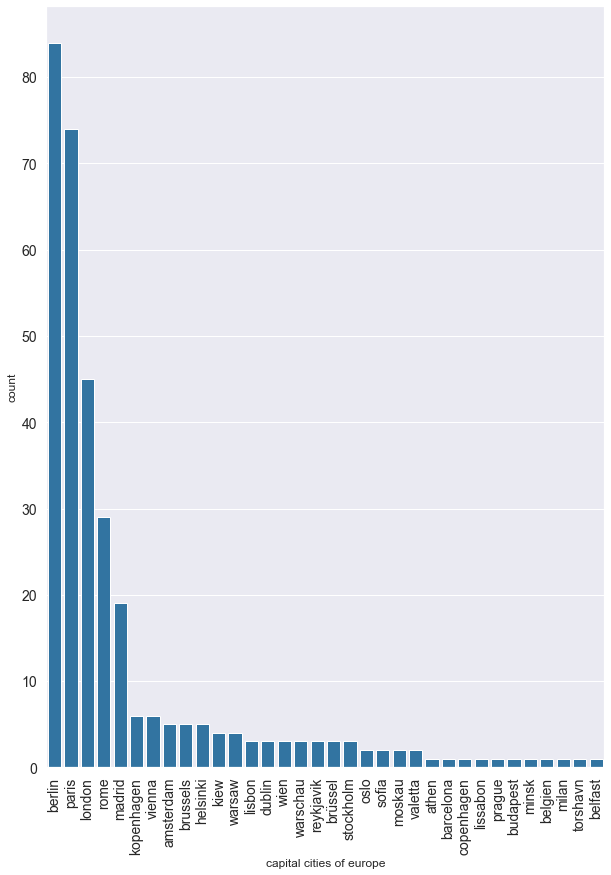

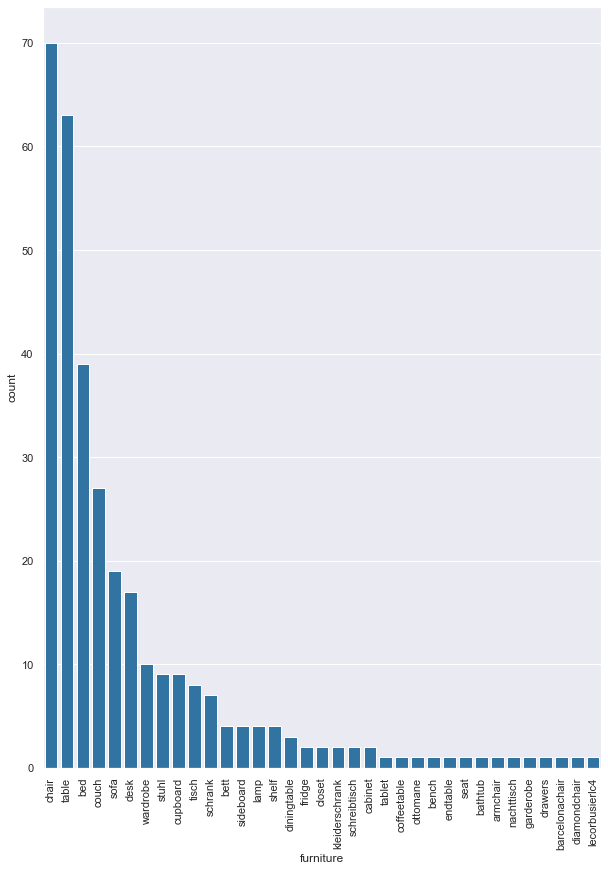

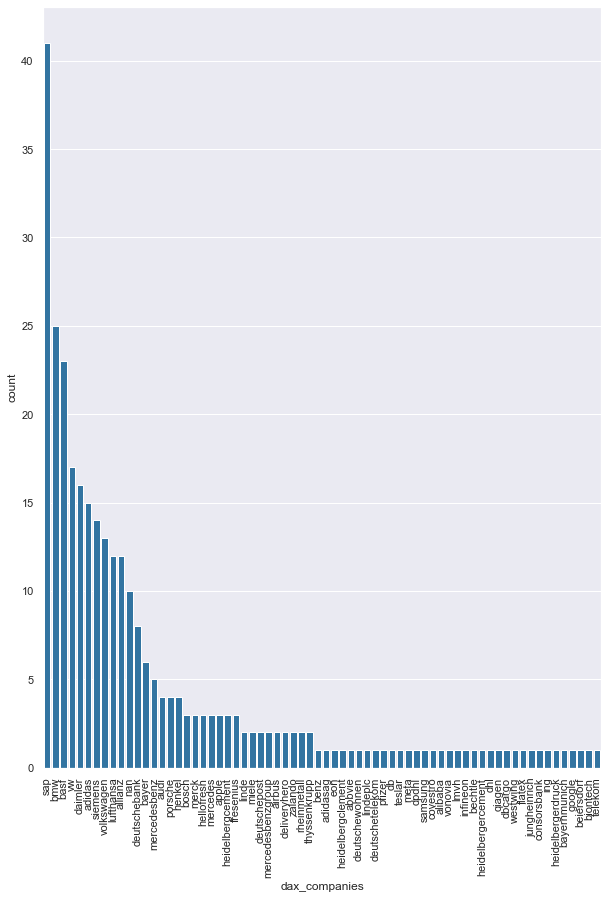

In [54]:
# Plot european capital cities
plt.figure()
sns.set_theme(style="darkgrid")
ax = sns.countplot(x='european_capital_cities', data=df_european_capital_cities, color='tab:blue', order = df_european_capital_cities['european_capital_cities'].value_counts().index)
sns.set(rc={'figure.figsize':(10, 14)})
plt.xticks(rotation=90);
plt.xlabel('capital cities of europe')
plt.tick_params(labelsize=14)

plt.savefig('../plots/european_capital_cities.png', bbox_inches="tight")   # save the figure to file

# Plot furniture
plt.figure()
sns.set_theme(style="darkgrid")
ax = sns.countplot(x='furniture', data=df_furniture, color='tab:blue', order = df_furniture['furniture'].value_counts().index)
sns.set(rc={'figure.figsize':(10, 14)})
plt.xticks(rotation=90);

# Plot dax companies
plt.figure()
sns.set_theme(style="darkgrid")
ax = sns.countplot(x='dax_companies', data=df_dax_companies, color='tab:blue', order = df_dax_companies['dax_companies'].value_counts().index)
sns.set(rc={'figure.figsize':(10, 14)})
plt.xticks(rotation=90);


## Translating values to english

In [55]:
# Function for translating the specialised dataframes into English using the DeepL API (www.deepl.com)

from deep_translator import DeeplTranslator
# https://github.com/nidhaloff/deep-translator
# Deepl API Key = 86ed8cd0-6f1c-8ade-b1bb-9e934b24f98a:fx
# Check https://www.deepl.com/pro-account/usage for character usage left (max. of 500,000 characters per month)

def cat_translator(data_frame, category_name_string):
    helper_df = data_frame
    helper_series = data_frame[category_name_string].tolist()
    trans_list = DeeplTranslator("86ed8cd0-6f1c-8ade-b1bb-9e934b24f98a:fx").translate_batch(helper_series)
    helper_df[category_name_string] = trans_list
    return helper_df

In [57]:
%%time

# translate
df_european_capital_cities_trans = cat_translator(df_european_capital_cities, 'european_capital_cities')

# save translated df as .csv-file because of the time and DeepL API constraints
df_european_capital_cities_trans.to_csv('../data/survey_single_cat_files/translated_df/df_european_capital_cities_trans.csv', sep=';', encoding='utf-8', index=False)
df_european_capital_cities_trans

CPU times: user 8.22 s, sys: 648 ms, total: 8.87 s
Wall time: 1min 46s


,european_capital_cities,p_age,p_gender,p_education,p_country,p_id
0,berlin,26,Male,Bachelor's degree,Germany,0
1,paris,26,Male,Bachelor's degree,Germany,0
2,london,26,Male,Bachelor's degree,Germany,0
3,amsterdam,44,Male,Doctorate (e.g. PhD),Germany,1
4,berlin,44,Male,Doctorate (e.g. PhD),Germany,1
...,...,...,...,...,...,...
321,rome,50,Female,Doctorate (e.g. PhD),Germany,107
322,london,50,Female,Doctorate (e.g. PhD),Germany,107
323,vienna,45,Female,Doctorate (e.g. PhD),Germany,108
324,berlin,45,Female,Doctorate (e.g. PhD),Germany,108


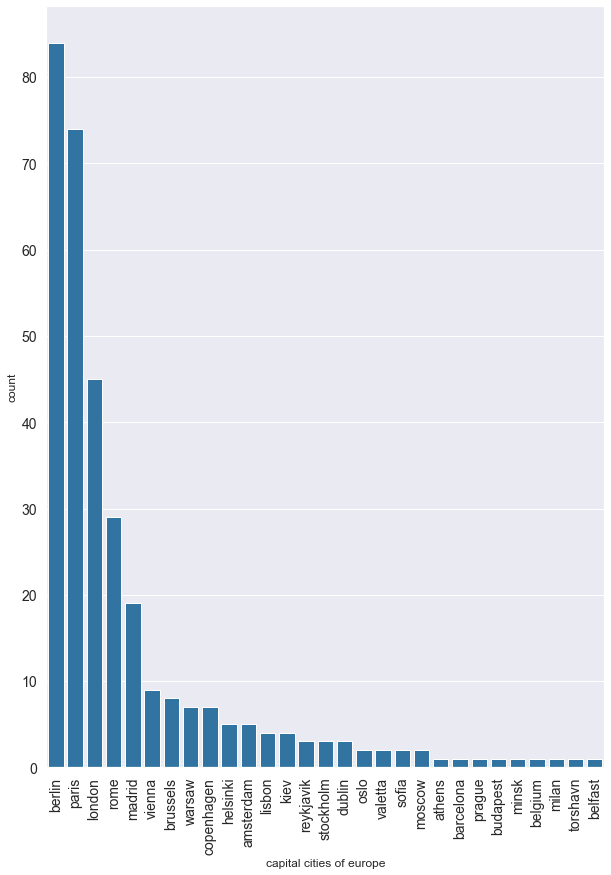

In [58]:
df_european_capital_cities_trans = pd.read_csv('../data/survey_single_cat_files/translated_df/df_european_capital_cities_trans.csv', sep=';')

# Plot european capital cities(translated)
plt.figure()
sns.set_theme(style="darkgrid")
ax = sns.countplot(x='european_capital_cities', data=df_european_capital_cities_trans, color='tab:blue', order = df_european_capital_cities_trans['european_capital_cities'].value_counts().index)
sns.set(rc={'figure.figsize':(10, 14)})
plt.xticks(rotation=90);
plt.xlabel('capital cities of europe')
plt.tick_params(labelsize=14)

plt.savefig('../plots/european_capital_cities_trans.png', bbox_inches="tight")   # save the figure to file

In [ ]:
# Plot furniture(translated)
plt.figure()
sns.set_theme(style="darkgrid")
ax = sns.countplot(x='furniture', data=df_furniture_trans)
sns.set(rc={'figure.figsize':(10, 14)})
plt.xticks(rotation=90);

In [26]:
%%time

# translate
df_cities_trans = cat_translator(df_cities, 'cities')

# save translated df as .csv-file because of the time and DeepL API constraints
df_cities_trans.to_csv('../data/survey_single_cat_files/translated_df/df_cities_trans.csv', sep=';', encoding='utf-8', index=False)
df_cities_trans

CPU times: user 8.14 s, sys: 702 ms, total: 8.84 s
Wall time: 2min 31s


,cities,p_age,p_gender,p_education,p_country,p_id
0,berlin,26,Male,Bachelor's degree,germany,0
1,newyork,26,Male,Bachelor's degree,germany,0
2,moscow,26,Male,Bachelor's degree,germany,0
3,newyork,44,Male,Doctorate (e.g. PhD),germany,1
4,amsterdam,44,Male,Doctorate (e.g. PhD),germany,1
...,...,...,...,...,...,...
321,munich,50,Female,Doctorate (e.g. PhD),germany,107
322,hamburg,50,Female,Doctorate (e.g. PhD),germany,107
323,newyork,45,Female,Doctorate (e.g. PhD),germany,108
324,hamburg,45,Female,Doctorate (e.g. PhD),germany,108


In [27]:
%%time

# translate
df_lakes_trans = cat_translator(df_lakes, 'lakes')

# save translated df as .csv-file because of the time and DeepL API constraints
df_lakes_trans.to_csv('../data/survey_single_cat_files/translated_df/df_lakes_trans.csv', sep=';', encoding='utf-8', index=False)
df_lakes_trans

CPU times: user 7.29 s, sys: 610 ms, total: 7.91 s
Wall time: 2min 10s


,lakes,p_age,p_gender,p_education,p_country,p_id
0,bodensee,26,Male,Bachelor's degree,germany,0
1,lakevictoria,26,Male,Bachelor's degree,germany,0
2,laketahoe,26,Male,Bachelor's degree,germany,0
3,lakegeneva,44,Male,Doctorate (e.g. PhD),germany,1
4,laketahoe,44,Male,Doctorate (e.g. PhD),germany,1
...,...,...,...,...,...,...
291,curvilinear,50,Female,Doctorate (e.g. PhD),germany,107
292,wannsee,50,Female,Doctorate (e.g. PhD),germany,107
293,tegernsee,45,Female,Doctorate (e.g. PhD),germany,108
294,starnbergersee,45,Female,Doctorate (e.g. PhD),germany,108


In [28]:
%%time

# translate
df_mountains_trans = cat_translator(df_mountains, 'mountains')

# save translated df as .csv-file because of the time and DeepL API constraints
df_mountains_trans.to_csv('../data/survey_single_cat_files/translated_df/df_mountains_trans.csv', sep=';', encoding='utf-8', index=False)
df_mountains_trans

CPU times: user 7.45 s, sys: 624 ms, total: 8.08 s
Wall time: 2min 32s


,mountains,p_age,p_gender,p_education,p_country,p_id
0,k2,26,Male,Bachelor's degree,germany,0
1,zugspitze,26,Male,Bachelor's degree,germany,0
2,chunk,26,Male,Bachelor's degree,germany,0
3,mounteverest,44,Male,Doctorate (e.g. PhD),germany,1
4,matterhorn,44,Male,Doctorate (e.g. PhD),germany,1
...,...,...,...,...,...,...
310,zugspitze,50,Female,Doctorate (e.g. PhD),germany,107
311,chunk,50,Female,Doctorate (e.g. PhD),germany,107
312,montblanc,45,Female,Doctorate (e.g. PhD),germany,108
313,zugspitze,45,Female,Doctorate (e.g. PhD),germany,108


In [15]:
%%time

# translate
df_european_countries_trans = cat_translator(df_european_countries, 'european_countries')

# save translated df as .csv-file because of the time and DeepL API constraints
df_european_countries_trans.to_csv('../data/survey_single_cat_files/translated_df/df_european_countries_trans.csv', sep=';', encoding='utf-8', index=False)
df_european_countries_trans

CPU times: user 8.11 s, sys: 672 ms, total: 8.78 s
Wall time: 1min 59s


,european_countries,p_age,p_gender,p_education,p_country,p_id
0,germany,26,Male,Bachelor's degree,germany,0
1,france,26,Male,Bachelor's degree,germany,0
2,italy,26,Male,Bachelor's degree,germany,0
3,germany,44,Male,Doctorate (e.g. PhD),germany,1
4,france,44,Male,Doctorate (e.g. PhD),germany,1
...,...,...,...,...,...,...
322,denmark,50,Female,Doctorate (e.g. PhD),germany,107
323,poland,50,Female,Doctorate (e.g. PhD),germany,107
324,lithuania,45,Female,Doctorate (e.g. PhD),germany,108
325,germany,45,Female,Doctorate (e.g. PhD),germany,108


In [16]:
%%time

# translate
df_asian_countries_trans = cat_translator(df_asian_countries, 'asian_countries')

# save translated df as .csv-file because of the time and DeepL API constraints
df_asian_countries_trans.to_csv('../data/survey_single_cat_files/translated_df/df_asian_countries_trans.csv', sep=';', encoding='utf-8', index=False)
df_asian_countries_trans

CPU times: user 7.62 s, sys: 774 ms, total: 8.4 s
Wall time: 2min 8s


,asian_countries,p_age,p_gender,p_education,p_country,p_id
0,japan,26,Male,Bachelor's degree,germany,0
1,china,26,Male,Bachelor's degree,germany,0
2,india,26,Male,Bachelor's degree,germany,0
3,china,44,Male,Doctorate (e.g. PhD),germany,1
4,japan,44,Male,Doctorate (e.g. PhD),germany,1
...,...,...,...,...,...,...
316,south korea,50,Female,Doctorate (e.g. PhD),germany,107
317,japan,50,Female,Doctorate (e.g. PhD),germany,107
318,china,45,Female,Doctorate (e.g. PhD),germany,108
319,vietnam,45,Female,Doctorate (e.g. PhD),germany,108


In [18]:
%%time

# translate
df_continents_trans = cat_translator(df_continents, 'continents')

# save translated df as .csv-file because of the time and DeepL API constraints
df_continents_trans.to_csv('../data/survey_single_cat_files/translated_df/df_continents_trans.csv', sep=';', encoding='utf-8', index=False)
df_continents_trans

CPU times: user 7.95 s, sys: 661 ms, total: 8.61 s
Wall time: 2min 46s


,continents,p_age,p_gender,p_education,p_country,p_id
0,europe,26,Male,Bachelor's degree,germany,0
1,africa,26,Male,Bachelor's degree,germany,0
2,asia,26,Male,Bachelor's degree,germany,0
3,europe,44,Male,Doctorate (e.g. PhD),germany,1
4,africa,44,Male,Doctorate (e.g. PhD),germany,1
...,...,...,...,...,...,...
320,europe,50,Female,Doctorate (e.g. PhD),germany,107
321,africa,50,Female,Doctorate (e.g. PhD),germany,107
322,asia,45,Female,Doctorate (e.g. PhD),germany,108
323,north america,45,Female,Doctorate (e.g. PhD),germany,108


In [19]:
%%time

# translate
df_birds_trans = cat_translator(df_birds, 'birds')

# save translated df as .csv-file because of the time and DeepL API constraints
df_birds_trans.to_csv('../data/survey_single_cat_files/translated_df/df_birds_trans.csv', sep=';', encoding='utf-8', index=False)
df_birds_trans

CPU times: user 7.52 s, sys: 645 ms, total: 8.16 s
Wall time: 1min 54s


,birds,p_age,p_gender,p_education,p_country,p_id
0,robin,26,Male,Bachelor's degree,germany,0
1,mockingbird,26,Male,Bachelor's degree,germany,0
2,pelican,26,Male,Bachelor's degree,germany,0
3,ostrich,44,Male,Doctorate (e.g. PhD),germany,1
4,owl,44,Male,Doctorate (e.g. PhD),germany,1
...,...,...,...,...,...,...
298,eagle,50,Female,Doctorate (e.g. PhD),germany,107
299,falcon,50,Female,Doctorate (e.g. PhD),germany,107
300,flamingo,45,Female,Doctorate (e.g. PhD),germany,108
301,swan,45,Female,Doctorate (e.g. PhD),germany,108


In [20]:
%%time

# translate
df_african_animals_trans = cat_translator(df_african_animals, 'african_animals')

# save translated df as .csv-file because of the time and DeepL API constraints
df_african_animals_trans.to_csv('../data/survey_single_cat_files/translated_df/df_african_animals_trans.csv', sep=';', encoding='utf-8', index=False)
df_african_animals_trans

CPU times: user 7.64 s, sys: 639 ms, total: 8.27 s
Wall time: 2min 14s


,african_animals,p_age,p_gender,p_education,p_country,p_id
0,lion,26,Male,Bachelor's degree,germany,0
1,elephant,26,Male,Bachelor's degree,germany,0
2,honeybadger,26,Male,Bachelor's degree,germany,0
3,elephant,44,Male,Doctorate (e.g. PhD),germany,1
4,lion,44,Male,Doctorate (e.g. PhD),germany,1
...,...,...,...,...,...,...
316,elephant,50,Female,Doctorate (e.g. PhD),germany,107
317,cheeta,50,Female,Doctorate (e.g. PhD),germany,107
318,leopard,45,Female,Doctorate (e.g. PhD),germany,108
319,elephant,45,Female,Doctorate (e.g. PhD),germany,108


In [21]:
%%time

# translate
df_furniture_trans = cat_translator(df_furniture, 'furniture')

# save translated df as .csv-file because of the time and DeepL API constraints
df_furniture_trans.to_csv('../data/survey_single_cat_files/translated_df/df_furniture_trans.csv', sep=';', encoding='utf-8', index=False)
df_furniture_trans

CPU times: user 8.18 s, sys: 633 ms, total: 8.81 s
Wall time: 2min 8s


,furniture,p_age,p_gender,p_education,p_country,p_id
0,chair,26,Male,Bachelor's degree,germany,0
1,table,26,Male,Bachelor's degree,germany,0
2,lamp,26,Male,Bachelor's degree,germany,0
3,chair,44,Male,Doctorate (e.g. PhD),germany,1
4,table,44,Male,Doctorate (e.g. PhD),germany,1
...,...,...,...,...,...,...
316,table,50,Female,Doctorate (e.g. PhD),germany,107
317,sofa,50,Female,Doctorate (e.g. PhD),germany,107
318,cupboard,45,Female,Doctorate (e.g. PhD),germany,108
319,table,45,Female,Doctorate (e.g. PhD),germany,108


In [22]:
%%time

# translate
df_vegetables_trans = cat_translator(df_vegetables, 'vegetables')

# save translated df as .csv-file because of the time and DeepL API constraints
df_vegetables_trans.to_csv('../data/survey_single_cat_files/translated_df/df_vegetables_trans.csv', sep=';', encoding='utf-8', index=False)
df_vegetables_trans

CPU times: user 8.12 s, sys: 616 ms, total: 8.74 s
Wall time: 2min 28s


,vegetables,p_age,p_gender,p_education,p_country,p_id
0,peas,26,Male,Bachelor's degree,germany,0
1,carrot,26,Male,Bachelor's degree,germany,0
2,tomato,26,Male,Bachelor's degree,germany,0
3,cucumber,44,Male,Doctorate (e.g. PhD),germany,1
4,tomato,44,Male,Doctorate (e.g. PhD),germany,1
...,...,...,...,...,...,...
311,turnip,50,Female,Doctorate (e.g. PhD),germany,107
312,cucumber,50,Female,Doctorate (e.g. PhD),germany,107
313,onion,45,Female,Doctorate (e.g. PhD),germany,108
314,potato,45,Female,Doctorate (e.g. PhD),germany,108


In [23]:
%%time

# translate
df_fast_food_trans = cat_translator(df_fast_food, 'fast_food')

# save translated df as .csv-file because of the time and DeepL API constraints
df_fast_food_trans.to_csv('../data/survey_single_cat_files/translated_df/df_fast_food_trans.csv', sep=';', encoding='utf-8', index=False)
df_fast_food_trans

CPU times: user 8.04 s, sys: 625 ms, total: 8.66 s
Wall time: 2min 41s


,fast_food,p_age,p_gender,p_education,p_country,p_id
0,fries,26,Male,Bachelor's degree,germany,0
1,burger,26,Male,Bachelor's degree,germany,0
2,pizza,26,Male,Bachelor's degree,germany,0
3,burger,44,Male,Doctorate (e.g. PhD),germany,1
4,pizza,44,Male,Doctorate (e.g. PhD),germany,1
...,...,...,...,...,...,...
313,burger,50,Female,Doctorate (e.g. PhD),germany,107
314,fries,50,Female,Doctorate (e.g. PhD),germany,107
315,pizza,45,Female,Doctorate (e.g. PhD),germany,108
316,hamburger,45,Female,Doctorate (e.g. PhD),germany,108


In [25]:
%%time

# translate
df_european_landmarks_trans = cat_translator(df_european_landmarks, 'european_landmarks')

# save translated df as .csv-file because of the time and DeepL API constraints
df_european_landmarks_trans.to_csv('../data/survey_single_cat_files/translated_df/df_european_landmarks_trans.csv', sep=';', encoding='utf-8', index=False)
df_european_landmarks_trans

CPU times: user 7.8 s, sys: 665 ms, total: 8.46 s
Wall time: 2min 8s


,european_landmarks,p_age,p_gender,p_education,p_country,p_id
0,eiffel tower,26,Male,Bachelor's degree,germany,0
1,brandenburggate,26,Male,Bachelor's degree,germany,0
2,colosseum,26,Male,Bachelor's degree,germany,0
3,eiffel tower,44,Male,Doctorate (e.g. PhD),germany,1
4,towerbridge,44,Male,Doctorate (e.g. PhD),germany,1
...,...,...,...,...,...,...
308,towerbridge,50,Female,Doctorate (e.g. PhD),germany,107
309,versaillespalace,50,Female,Doctorate (e.g. PhD),germany,107
310,louvre,45,Female,Doctorate (e.g. PhD),germany,108
311,alhambra,45,Female,Doctorate (e.g. PhD),germany,108


## Other

In [13]:
# https://lookup.dbpedia.org/
lookup_url = 'https://lookup.dbpedia.org/api/search?query='
response = requests.get(lookup_url + 'Mannheim')

In [17]:
response.json()

JSONDecodeError: [Errno Expecting value] <?xml version="1.0" encoding="UTF-8"?><ArrayOfResults><Result><Label>SV Waldhof Mannheim</Label><URI>http://dbpedia.org/resource/SV_Waldhof_Mannheim</URI><Description>SV Waldhof Mannheim is a multi-sports club, located in Mannheim, Baden-Württemberg. It is most known for its association football team; however, there are also professional handball and table-tennis sides. The club today has a membership of over 2,400.</Description><Classes><Class><Label>Organisation</Label><URI>http://dbpedia.org/ontology/Organisation</URI></Class><Class><Label>Soccer Club</Label><URI>http://dbpedia.org/ontology/SoccerClub</URI></Class><Class><Label>Agent</Label><URI>http://dbpedia.org/ontology/Agent</URI></Class><Class><Label>Sports Club</Label><URI>http://dbpedia.org/ontology/SportsClub</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:Football_clubs_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Football_clubs_in_Baden-Württemberg</URI></Category><Category><URI>http://dbpedia.org/resource/Category:1907_establishments_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Association_football_clubs_established_in_1907</URI></Category><Category><URI>http://dbpedia.org/resource/Category:SV_Waldhof_Mannheim</URI></Category></Categories><Refcount>698</Refcount></Result><Result><Label>Mannheim</Label><URI>http://dbpedia.org/resource/Mannheim</URI><Description>Mannheim (German pronunciation: [ˈmanhaɪm] (); Palatine German: Monnem or Mannem) is a city in the southwestern part of Germany, the third-largest in the German state of Baden-Württemberg after Stuttgart and Karlsruhe with a 2015 population of approximately 310,000 inhabitants. The city is at the centre of the larger densely populated Rhine-Neckar Metropolitan Region which has a population of 2,400,000 and is Germany's eighth-largest metropolitan region.</Description><Classes><Class><Label>Settlement</Label><URI>http://dbpedia.org/ontology/Settlement</URI></Class><Class><Label>City</Label><URI>http://dbpedia.org/ontology/City</URI></Class><Class><Label>Place</Label><URI>http://dbpedia.org/ontology/Place</URI></Class><Class><Label>Populated Place</Label><URI>http://dbpedia.org/ontology/PopulatedPlace</URI></Class><Class><Label>Location</Label><URI>http://dbpedia.org/ontology/Location</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:Holocaust_locations_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:University_towns_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Planned_capitals</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Baden</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Historic_Jewish_communities</URI></Category><Category><URI>http://dbpedia.org/resource/Category:History_of_the_Palatinate_(region)</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Populated_places_on_the_Rhine</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Karlsruhe_(region)</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Mannheim</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Cities_in_Baden-Württemberg</URI></Category></Categories><Refcount>297</Refcount></Result><Result><Label>Adler Mannheim</Label><URI>http://dbpedia.org/resource/Adler_Mannheim</URI><Description>The Adler Mannheim ('Mannheim Eagles', formerly Mannheimer ERC) are a professional ice hockey team of the Deutsche Eishockey Liga, the highest-level ice hockey league in Germany. The team is based in Mannheim, a city in the northern part of Baden-Württemberg. Currently, the team plays at SAP Arena, where they moved to at the beginning of the 2005–06 season after having played at Eisstadion am Friedrichspark for nearly seven decades from 1938 through 2005. They have won the German Championship a total of eight times, seven of those coming after 1994 in the Deutsche Eishockey Liga.</Description><Classes><Class><Label>Organisation</Label><URI>http://dbpedia.org/ontology/Organisation</URI></Class><Class><Label>Hockey Team</Label><URI>http://dbpedia.org/ontology/HockeyTeam</URI></Class><Class><Label>Sports Team</Label><URI>http://dbpedia.org/ontology/SportsTeam</URI></Class><Class><Label>Agent</Label><URI>http://dbpedia.org/ontology/Agent</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:1938_establishments_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Deutsche_Eishockey_Liga_teams</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Ice_hockey_clubs_established_in_1938</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Ice_hockey_teams_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Sport_in_Mannheim</URI></Category></Categories><Refcount>181</Refcount></Result><Result><Label>VfR Mannheim</Label><URI>http://dbpedia.org/resource/VfR_Mannheim</URI><Description>VfR Mannheim is a German association football club based in Mannheim, Baden-Württemberg formed in 1911 out of the fusion of Mannheimer FG 1896, Mannheimer FG 1897 Union, and FC Viktoria 1897 Mannheim. The club captured the national title in 1949 with a victory over Borussia Dortmund. They have played through most of its recent history as an unheralded local amateur side and were, until 2015, part of the Oberliga Baden-Württemberg (V).</Description><Classes><Class><Label>Organisation</Label><URI>http://dbpedia.org/ontology/Organisation</URI></Class><Class><Label>Soccer Club</Label><URI>http://dbpedia.org/ontology/SoccerClub</URI></Class><Class><Label>Agent</Label><URI>http://dbpedia.org/ontology/Agent</URI></Class><Class><Label>Sports Club</Label><URI>http://dbpedia.org/ontology/SportsClub</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:Association_football_clubs_established_in_1911</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Football_clubs_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Football_clubs_in_Baden-Württemberg</URI></Category><Category><URI>http://dbpedia.org/resource/Category:1896_establishments_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:VfR_Mannheim</URI></Category></Categories><Refcount>165</Refcount></Result><Result><Label>University of Mannheim</Label><URI>http://dbpedia.org/resource/University_of_Mannheim</URI><Description>The University of Mannheim (in German: Universität Mannheim), abbreviated UMA, is a public research university in Mannheim, Baden-Württemberg, Germany. Founded in 1967, the university has its origins in the Palatine Academy of Sciences, which was established by Elector Carl Theodor at Mannheim Palace in 1763, as well as the Handelshochschule (Commercial College Mannheim), which was founded in 1907.</Description><Classes><Class><Label>Organisation</Label><URI>http://dbpedia.org/ontology/Organisation</URI></Class><Class><Label>University</Label><URI>http://dbpedia.org/ontology/University</URI></Class><Class><Label>Educational Institution</Label><URI>http://dbpedia.org/ontology/EducationalInstitution</URI></Class><Class><Label>Agent</Label><URI>http://dbpedia.org/ontology/Agent</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:1907_establishments_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Educational_institutions_established_in_1907</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Universities_and_colleges_in_Baden-Württemberg</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Buildings_and_structures_in_Mannheim</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Universities_established_in_the_1960s</URI></Category><Category><URI>http://dbpedia.org/resource/Category:University_of_Mannheim</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Tourist_attractions_in_Mannheim</URI></Category></Categories><Refcount>54</Refcount></Result><Result><Label>Mannheim school</Label><URI>http://dbpedia.org/resource/Mannheim_school</URI><Description>Mannheim school refers to both the orchestral techniques pioneered by the court orchestra of Mannheim in the latter half of the 18th century and the group of composers of the early classical period, who composed for the orchestra of Mannheim. The father of the school is considered to be the Bohemian composer Johann Stamitz. Besides him, two generations of composers wrote compositions for the orchestra, whose reputation was due to its excellent discipline and the individual skill of its players; the English traveler Charles Burney called it "an army of generals". Their performance style included new dynamic elements, crescendos and diminuendos. Composers of the Mannheim school played an important role in the development of the classical period's genres and of the classical symphony form.</Description><Classes/><Categories><Category><URI>http://dbpedia.org/resource/Category:Composition_schools</URI></Category><Category><URI>http://dbpedia.org/resource/Category:German_music</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Mannheim</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Classical_period_(music)</URI></Category></Categories><Refcount>13</Refcount></Result><Result><Label>Mannheim–Saarbrücken railway</Label><URI>http://dbpedia.org/resource/Mannheim–Saarbrücken_railway</URI><Description>The Mannheim–Saarbrücken railway is a railway in the German states of Baden-Württemberg, Rhineland-Palatinate and the Saarland that runs through Ludwigshafen am Rhein, Neustadt an der Weinstraße, Kaiserslautern, Homburg and St. Ingbert. It is the most important railway line that runs through the Palatinate. It serves both passenger and freight transport and carries international traffic.</Description><Classes><Class><Label>Place</Label><URI>http://dbpedia.org/ontology/Place</URI></Class><Class><Label>Railway Line</Label><URI>http://dbpedia.org/ontology/RailwayLine</URI></Class><Class><Label>Architectural Structure</Label><URI>http://dbpedia.org/ontology/ArchitecturalStructure</URI></Class><Class><Label>Location</Label><URI>http://dbpedia.org/ontology/Location</URI></Class><Class><Label>Infrastructure</Label><URI>http://dbpedia.org/ontology/Infrastructure</URI></Class><Class><Label>Route Of Transportation</Label><URI>http://dbpedia.org/ontology/RouteOfTransportation</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:Railway_lines_in_Rhineland-Palatinate</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Railway_lines_opened_in_1847</URI></Category><Category><URI>http://dbpedia.org/resource/Category:1847_establishments_in_Bavaria</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Buildings_and_structures_in_Saarbrücken</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Rhine-Neckar_S-Bahn</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Railway_lines_in_the_Saarland</URI></Category></Categories><Refcount>21</Refcount></Result><Result><Label>Bombardier Transportation</Label><URI>http://dbpedia.org/resource/Bombardier_Transportation</URI><Description>Bombardier Transportation is the rail equipment division of the Canadian multinational firm Bombardier Inc.. Bombardier Transportation is one of the world's largest companies in the rail vehicle and equipment manufacturing and servicing industry. Bombardier Transportation is headquartered in Berlin. There are many regional offices, production and development facilities worldwide. Bombardier Transportation produces a wide range of products including passenger rail vehicles, locomotives, bogies, propulsion and controls.</Description><Classes/><Categories><Category><URI>http://dbpedia.org/resource/Category:Manufacturing_companies_based_in_Berlin</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Bombardier_Inc.</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Bombardier_Transportation</URI></Category></Categories><Refcount>166</Refcount></Result><Result><Label>Mannheim University of Applied Sciences</Label><URI>http://dbpedia.org/resource/Mannheim_University_of_Applied_Sciences</URI><Description>The Mannheim University of Applied Sciences is a public university located in Mannheim, Germany. Referred to as Hochschule Mannheim in German and previously known as Fachhochschule Mannheim, it offers degree programs at bachelor's and master's level in the fields of engineering, informatics, biotechnology, design, and social affairs.</Description><Classes><Class><Label>Organisation</Label><URI>http://dbpedia.org/ontology/Organisation</URI></Class><Class><Label>University</Label><URI>http://dbpedia.org/ontology/University</URI></Class><Class><Label>Educational Institution</Label><URI>http://dbpedia.org/ontology/EducationalInstitution</URI></Class><Class><Label>Agent</Label><URI>http://dbpedia.org/ontology/Agent</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:Universities_and_colleges_in_Baden-Württemberg</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Educational_institutions_established_in_1898</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Universities_of_Applied_Sciences_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Technical_universities_and_colleges_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Mannheim</URI></Category></Categories><Refcount>9</Refcount></Result><Result><Label>Mannheim–Karlsruhe–Basel railway</Label><URI>http://dbpedia.org/resource/Mannheim–Karlsruhe–Basel_railway</URI><Description>The Mannheim–Karlsruhe–Basel railway is a double-track electrified mainline railway in the German state of Baden-Württemberg. It runs from Mannheim via Heidelberg, Bruchsal, Karlsruhe, Rastatt, Baden-Baden, Offenburg and Freiburg to Basel, Switzerland. It is also known as the Rhine Valley Railway (German: Rheintalbahn) or the Upper Rhine Railway (Oberrheinbahn). The Mannheim–Basel railway is one of the most important routes in the Deutsche Bahn network.</Description><Classes><Class><Label>Place</Label><URI>http://dbpedia.org/ontology/Place</URI></Class><Class><Label>Railway Line</Label><URI>http://dbpedia.org/ontology/RailwayLine</URI></Class><Class><Label>Architectural Structure</Label><URI>http://dbpedia.org/ontology/ArchitecturalStructure</URI></Class><Class><Label>Location</Label><URI>http://dbpedia.org/ontology/Location</URI></Class><Class><Label>Infrastructure</Label><URI>http://dbpedia.org/ontology/Infrastructure</URI></Class><Class><Label>Route Of Transportation</Label><URI>http://dbpedia.org/ontology/RouteOfTransportation</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:Buildings_and_structures_in_Breisgau-Hochschwarzwald</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Railway_lines_in_Baden-Württemberg</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Buildings_and_structures_in_Ortenaukreis</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Rhine_Valley_Railway</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Karlsruhe_Stadtbahn</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Rail_transport_in_Karlsruhe</URI></Category><Category><URI>http://dbpedia.org/resource/Category:High-speed_railway_lines_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Cross-border_railway_lines_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Buildings_and_structures_in_Karlsruhe_(district)</URI></Category><Category><URI>http://dbpedia.org/resource/Category:1840_establishments_in_Baden</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Railway_lines_opened_in_1840</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Emmendingen_(district)</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Buildings_and_structures_in_Lörrach_(district)</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Rhine-Neckar_S-Bahn</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Transport_in_Mannheim</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Buildings_and_structures_in_Rhein-Neckar-Kreis</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Transport_in_Heidelberg</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Cross-border_railway_lines_in_Switzerland</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Buildings_and_structures_in_Rastatt_(district)</URI></Category></Categories><Refcount>19</Refcount></Result><Result><Label>International Filmfestival Mannheim-Heidelberg</Label><URI>http://dbpedia.org/resource/International_Filmfestival_Mannheim-Heidelberg</URI><Description>Mannheim-Heidelberg International Filmfestival (German: Internationales Filmfestival Mannheim-Heidelberg), often shortened to IFFMH, is an annual film festival held jointly by the cities of Mannheim and Heidelberg in Baden-Württemberg. The festival was established in 1952. The festival presents arthouse films of international newcomer directors. It is the second-oldest film festival in Germany (the oldest being Berlin). Since 1994 it has been held jointly by the cities of Mannheim and Heidelberg. The festival takes place annually around November.</Description><Classes><Class><Label>Film Festival</Label><URI>http://dbpedia.org/ontology/FilmFestival</URI></Class><Class><Label>Event</Label><URI>http://dbpedia.org/ontology/Event</URI></Class><Class><Label>Societal Event</Label><URI>http://dbpedia.org/ontology/SocietalEvent</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:Recurring_events_established_in_1952</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Culture_of_Baden-Württemberg</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Tourist_attractions_in_Heidelberg</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Film_festivals_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Film_festivals_established_in_1952</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Tourist_attractions_in_Mannheim</URI></Category></Categories><Refcount>10</Refcount></Result><Result><Label>Lucie Mannheim</Label><URI>http://dbpedia.org/resource/Lucie_Mannheim</URI><Description>Lucie Mannheim (30 April 1899 – 28 July 1976) was a German singer and actress.</Description><Classes><Class><Label>Person</Label><URI>http://dbpedia.org/ontology/Person</URI></Class><Class><Label>Agent</Label><URI>http://dbpedia.org/ontology/Agent</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:1899_births</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Women_in_World_War_II</URI></Category><Category><URI>http://dbpedia.org/resource/Category:20th-century_women_singers</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Commanders_Crosses_of_the_Order_of_Merit_of_the_Federal_Republic_of_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:1976_deaths</URI></Category><Category><URI>http://dbpedia.org/resource/Category:20th-century_German_actresses</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Actresses_from_Berlin</URI></Category><Category><URI>http://dbpedia.org/resource/Category:German_film_actresses</URI></Category><Category><URI>http://dbpedia.org/resource/Category:German_silent_film_actresses</URI></Category><Category><URI>http://dbpedia.org/resource/Category:German_stage_actresses</URI></Category><Category><URI>http://dbpedia.org/resource/Category:20th-century_German_musicians</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Jewish_emigrants_from_Nazi_Germany_to_the_United_Kingdom</URI></Category><Category><URI>http://dbpedia.org/resource/Category:German_female_singers</URI></Category><Category><URI>http://dbpedia.org/resource/Category:German_expatriates_in_England</URI></Category></Categories><Refcount>8</Refcount></Result><Result><Label>Mannheim City Airport</Label><URI>http://dbpedia.org/resource/Mannheim_City_Airport</URI><Description>Mannheim City Airport (IATA: MHG, ICAO: EDFM) (City-Airport Mannheim in German, formerly Mannheim-Neuostheim/Neuhermsheim) is a minor regional airport serving the German city of Mannheim. It is mainly used for general aviation.</Description><Classes><Class><Label>Airport</Label><URI>http://dbpedia.org/ontology/Airport</URI></Class><Class><Label>Place</Label><URI>http://dbpedia.org/ontology/Place</URI></Class><Class><Label>Architectural Structure</Label><URI>http://dbpedia.org/ontology/ArchitecturalStructure</URI></Class><Class><Label>Location</Label><URI>http://dbpedia.org/ontology/Location</URI></Class><Class><Label>Infrastructure</Label><URI>http://dbpedia.org/ontology/Infrastructure</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:1911_establishments_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Airports_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Buildings_and_structures_in_Mannheim</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Airports_established_in_1911</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Aviation_in_Baden-Württemberg</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Transport_in_Mannheim</URI></Category></Categories><Refcount>8</Refcount></Result><Result><Label>Ralph Manheim</Label><URI>http://dbpedia.org/resource/Ralph_Manheim</URI><Description>Ralph Frederick Manheim (April 4, 1907 – September 26, 1992) was an American translator of German and French literature, as well as occasional works from Dutch, Polish and Hungarian. He was one of most acclaimed translators of the 20th century, and likened translation to acting, the role being "to impersonate his author".</Description><Classes/><Categories><Category><URI>http://dbpedia.org/resource/Category:20th-century_translators</URI></Category><Category><URI>http://dbpedia.org/resource/Category:American_translators</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Writers_from_New_York_City</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Harvard_University_alumni</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Yale_University_alumni</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Guggenheim_Fellows</URI></Category><Category><URI>http://dbpedia.org/resource/Category:1992_deaths</URI></Category><Category><URI>http://dbpedia.org/resource/Category:1907_births</URI></Category><Category><URI>http://dbpedia.org/resource/Category:MacArthur_Fellows</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Columbia_University_alumni</URI></Category><Category><URI>http://dbpedia.org/resource/Category:National_Book_Award_winners</URI></Category><Category><URI>http://dbpedia.org/resource/Category:American_expatriates_in_France</URI></Category><Category><URI>http://dbpedia.org/resource/Category:French–English_translators</URI></Category><Category><URI>http://dbpedia.org/resource/Category:German–English_translators</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Mein_Kampf</URI></Category></Categories><Refcount>20</Refcount></Result><Result><Label>Mannheim Hauptbahnhof</Label><URI>http://dbpedia.org/resource/Mannheim_Hauptbahnhof</URI><Description>Mannheim Hauptbahnhof (German for Mannheim main station) is a railway station in Mannheim in the German state of Baden-Württemberg. It is the second largest traffic hub in southwestern Germany after Stuttgart Hauptbahnhof, with 658 trains a day, including 238 long-distance trains. It is also a key station in the Rhine-Neckar S-Bahn. 100,000 passengers embark, disembark or transfer between trains at the station each day. The station was modernised in 2001. It is classified by Deutsche Bahn as a category 2 station.</Description><Classes><Class><Label>Station</Label><URI>http://dbpedia.org/ontology/Station</URI></Class><Class><Label>Place</Label><URI>http://dbpedia.org/ontology/Place</URI></Class><Class><Label>Architectural Structure</Label><URI>http://dbpedia.org/ontology/ArchitecturalStructure</URI></Class><Class><Label>Location</Label><URI>http://dbpedia.org/ontology/Location</URI></Class><Class><Label>Infrastructure</Label><URI>http://dbpedia.org/ontology/Infrastructure</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:Railway_stations_opened_in_1840</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Rhine-Neckar_S-Bahn_stations</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Buildings_and_structures_in_Mannheim</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Railway_stations_in_Mannheim</URI></Category></Categories><Refcount>5</Refcount></Result><Result><Label>Mannheim–Stuttgart high-speed railway</Label><URI>http://dbpedia.org/resource/Mannheim–Stuttgart_high-speed_railway</URI><Description>The Mannheim–Stuttgart high-speed railway is a 99 km long railway line in Germany, connecting the cities of Mannheim and Stuttgart. The line was officially opened on 9 May 1991, and InterCityExpress service began on 2 June. The Hanover–Würzburg high-speed railway also opened at the same time. The line cost about DM 4.5 billion to build and has 15 tunnels and more than 90 bridges.</Description><Classes><Class><Label>Place</Label><URI>http://dbpedia.org/ontology/Place</URI></Class><Class><Label>Railway Line</Label><URI>http://dbpedia.org/ontology/RailwayLine</URI></Class><Class><Label>Architectural Structure</Label><URI>http://dbpedia.org/ontology/ArchitecturalStructure</URI></Class><Class><Label>Location</Label><URI>http://dbpedia.org/ontology/Location</URI></Class><Class><Label>Infrastructure</Label><URI>http://dbpedia.org/ontology/Infrastructure</URI></Class><Class><Label>Route Of Transportation</Label><URI>http://dbpedia.org/ontology/RouteOfTransportation</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:Railway_lines_in_Baden-Württemberg</URI></Category><Category><URI>http://dbpedia.org/resource/Category:High-speed_railway_lines_in_Germany</URI></Category></Categories><Refcount>7</Refcount></Result><Result><Label>Mannheim Palace</Label><URI>http://dbpedia.org/resource/Mannheim_Palace</URI><Description>Mannheim Palace (German: Mannheimer Schloss) is a large Baroque palace in Mannheim, Baden-Württemberg, Germany. It was originally the main residence of the Prince-electors of the Electorate of the Palatinate of the House of Wittelsbach. Part of the palace is used by the University of Mannheim. The castle, which features tapestries, furniture, paintings, porcelain and silverware can be visited on a free-flow basis with audioguides.</Description><Classes/><Categories><Category><URI>http://dbpedia.org/resource/Category:Royal_residences_in_Baden-Württemberg</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Buildings_and_structures_in_Mannheim</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Baroque_palaces</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Baroque_architecture_in_Baden-Württemberg</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Electoral_Palatinate</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Historic_house_museums_in_Baden-Württemberg</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Episcopal_palaces_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Palaces_in_Baden-Württemberg</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Tourist_attractions_in_Mannheim</URI></Category></Categories><Refcount>4</Refcount></Result><Result><Label>Mannheim station (Illinois)</Label><URI>http://dbpedia.org/resource/Mannheim_station_(Illinois)</URI><Description>Mannheim is a station on Metra's Milwaukee District/West in Franklin Park, Illinois that gets services during rush hour. The station is 14.0 miles (22.5 km) away from Union Station, the eastern terminus of the line. In Metra's zone-based fare system, Mannheim is in zone C. The reason this station is named because of Mannheim Road running right next to it. It is the only non-ADA-accessible station on the Milwaukee District West Line.</Description><Classes><Class><Label>Station</Label><URI>http://dbpedia.org/ontology/Station</URI></Class><Class><Label>Place</Label><URI>http://dbpedia.org/ontology/Place</URI></Class><Class><Label>Architectural Structure</Label><URI>http://dbpedia.org/ontology/ArchitecturalStructure</URI></Class><Class><Label>Location</Label><URI>http://dbpedia.org/ontology/Location</URI></Class><Class><Label>Infrastructure</Label><URI>http://dbpedia.org/ontology/Infrastructure</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:Metra_stations_in_Illinois</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Railway_stations_in_Cook_County,_Illinois</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Former_Chicago,_Milwaukee,_St._Paul_and_Pacific_Railroad_stations</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Franklin_Park,_Illinois</URI></Category></Categories><Refcount>4</Refcount></Result><Result><Label>Bruno Mannheim</Label><URI>http://dbpedia.org/resource/Bruno_Mannheim</URI><Description>Bruno "Ugly" Mannheim is a villain who appears in DC Comics as one of Superman's enemies.</Description><Classes><Class><Label>Comics Character</Label><URI>http://dbpedia.org/ontology/ComicsCharacter</URI></Class><Class><Label>Fictional Character</Label><URI>http://dbpedia.org/ontology/FictionalCharacter</URI></Class><Class><Label>Agent</Label><URI>http://dbpedia.org/ontology/Agent</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:Fictional_gangsters</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Fictional_murderers</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Characters_created_by_Jack_Kirby</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Fictional_giants</URI></Category><Category><URI>http://dbpedia.org/resource/Category:DC_Comics_supervillains</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Comics_characters_introduced_in_1971</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Fictional_cannibals</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Superman_characters</URI></Category></Categories><Refcount>3</Refcount></Result><Result><Label>Karl Mannheim</Label><URI>http://dbpedia.org/resource/Karl_Mannheim</URI><Description>Karl Mannheim (born Károly Manheim, 27 March 1893 – 9 January 1947) was an influential German sociologist during the first half of the 20th century. He was a founding father of classical sociology, as well as idea of sociology of knowledge. Mannheim is known for Ideology and Utopia (1929) wherein he argues that ideologies are representative of the true nature of a society, and that, in trying to achieve a utopia, the dogmas of ideology affect the intellectual integrity of theories of philosophy and theories of history.</Description><Classes><Class><Label>Person</Label><URI>http://dbpedia.org/ontology/Person</URI></Class><Class><Label>Scientist</Label><URI>http://dbpedia.org/ontology/Scientist</URI></Class><Class><Label>Agent</Label><URI>http://dbpedia.org/ontology/Agent</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:Hungarian_Jews</URI></Category><Category><URI>http://dbpedia.org/resource/Category:1893_births</URI></Category><Category><URI>http://dbpedia.org/resource/Category:1947_deaths</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Academics_of_the_London_School_of_Economics</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Goethe_University_Frankfurt_faculty</URI></Category><Category><URI>http://dbpedia.org/resource/Category:People_from_the_Kingdom_of_Hungary</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Heidelberg_University_faculty</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Jewish_emigrants_from_Nazi_Germany_to_the_United_Kingdom</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Jewish_sociologists</URI></Category><Category><URI>http://dbpedia.org/resource/Category:20th-century_Hungarian_male_writers</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Writers_from_Budapest</URI></Category><Category><URI>http://dbpedia.org/resource/Category:20th-century_Hungarian_writers</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Hungarian_sociologists</URI></Category></Categories><Refcount>4</Refcount></Result><Result><Label>Mannheim Road</Label><URI>http://dbpedia.org/resource/Mannheim_Road</URI><Description>Mannheim Road, also known as La Grange Road from Cermak Road to U.S. Route 30 (Lincoln Highway), is a north–south major street in the near-western suburbs of Chicago. It carries U.S. Routes 12 from Des Plaines to 95th St near Hickory Hills, 45 between Des Plaines on southwards past Frankfort, Illinois and carries U.S. Route 20 between Lake Street in Stone Park, Illinois and 95th St. near Hickory Hills, Illinois The road is named after a former town called Mannheim, Illinois that was founded by German farmers in what is now Franklin Park, Illinois. From Cermak Road on the Westchester/La Grange Park border and points to the south, it is known as La Grange Road. Mannheim Road skirts the eastern edge of O'Hare International Airport; numerous airport hotels and rental car services are located o</Description><Classes><Class><Label>Road</Label><URI>http://dbpedia.org/ontology/Road</URI></Class><Class><Label>Place</Label><URI>http://dbpedia.org/ontology/Place</URI></Class><Class><Label>Architectural Structure</Label><URI>http://dbpedia.org/ontology/ArchitecturalStructure</URI></Class><Class><Label>Location</Label><URI>http://dbpedia.org/ontology/Location</URI></Class><Class><Label>Infrastructure</Label><URI>http://dbpedia.org/ontology/Infrastructure</URI></Class><Class><Label>Route Of Transportation</Label><URI>http://dbpedia.org/ontology/RouteOfTransportation</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:U.S._Route_12</URI></Category><Category><URI>http://dbpedia.org/resource/Category:U.S._Route_20</URI></Category><Category><URI>http://dbpedia.org/resource/Category:U.S._Route_45</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Streets_in_Illinois</URI></Category></Categories><Refcount>5</Refcount></Result><Result><Label>Amédée Mannheim</Label><URI>http://dbpedia.org/resource/Amédée_Mannheim</URI><Description>Victor Mayer Amédée Mannheim (17 July 1831 in Paris, France – 11 December 1906 in Paris, France) was the inventor of the modern slide rule. Around 1850, he introduced a new scale system that used a runner to perform calculations. This type of slide rule became known under the name of its inventor: the Mannheim.</Description><Classes><Class><Label>Person</Label><URI>http://dbpedia.org/ontology/Person</URI></Class><Class><Label>Scientist</Label><URI>http://dbpedia.org/ontology/Scientist</URI></Class><Class><Label>Agent</Label><URI>http://dbpedia.org/ontology/Agent</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:1831_births</URI></Category><Category><URI>http://dbpedia.org/resource/Category:20th-century_mathematicians</URI></Category><Category><URI>http://dbpedia.org/resource/Category:1906_deaths</URI></Category><Category><URI>http://dbpedia.org/resource/Category:19th-century_French_mathematicians</URI></Category></Categories><Refcount>3</Refcount></Result><Result><Label>Hochschule für Musik und Darstellende Kunst Mannheim</Label><URI>http://dbpedia.org/resource/Hochschule_für_Musik_und_Darstellende_Kunst_Mannheim</URI><Description>The Staatliche Hochschule für Musik und Darstellende Kunst Mannheim is a Hochschule, a university for music and performing arts in Mannheim, Germany, of the state Baden-Württemberg</Description><Classes/><Categories><Category><URI>http://dbpedia.org/resource/Category:1971_establishments_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Universities_and_colleges_in_Baden-Württemberg</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Universities_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Music_schools_in_Germany</URI></Category></Categories><Refcount>6</Refcount></Result><Result><Label>Halloween (Mannheim Steamroller album)</Label><URI>http://dbpedia.org/resource/Halloween_(Mannheim_Steamroller_album)</URI><Description>Halloween is the first Halloween album by Mannheim Steamroller. It is a double album.</Description><Classes><Class><Label>Album</Label><URI>http://dbpedia.org/ontology/Album</URI></Class><Class><Label>Musical Work</Label><URI>http://dbpedia.org/ontology/MusicalWork</URI></Class><Class><Label>Work</Label><URI>http://dbpedia.org/ontology/Work</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:2003_albums</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Mannheim_Steamroller_albums</URI></Category><Category><URI>http://dbpedia.org/resource/Category:American_Gramaphone_albums</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Halloween_albums</URI></Category></Categories><Refcount>4</Refcount></Result><Result><Label>Mannheim National Theatre</Label><URI>http://dbpedia.org/resource/Mannheim_National_Theatre</URI><Description>The Mannheim National Theatre (German: Nationaltheater Mannheim) is a theatre and opera company in Mannheim, Germany, with a variety of performance spaces. It was founded in 1779 and is one of the oldest theatres in Germany.</Description><Classes/><Categories><Category><URI>http://dbpedia.org/resource/Category:1957_establishments_in_West_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Opera_houses_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:National_theatres</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Theatres_in_Baden-Württemberg</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Buildings_and_structures_in_Mannheim</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Theatre_companies_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:German_opera_companies</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Music_venues_completed_in_1957</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Theatres_completed_in_1957</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Theatres_completed_in_1779</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Tourist_attractions_in_Mannheim</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Music_venues_completed_in_1779</URI></Category></Categories><Refcount>3</Refcount></Result><Result><Label>Mannheim process</Label><URI>http://dbpedia.org/resource/Mannheim_process</URI><Description>The Mannheim process is an industrial process for the production of hydrogen chloride and sodium sulfate from sulfuric acid and sodium chloride. The Mannheim furnace is also used to produce potassium sulfate from potassium chloride. The Mannheim process is a stage in the Leblanc process for the production of sodium carbonate.</Description><Classes/><Categories><Category><URI>http://dbpedia.org/resource/Category:Chemical_processes</URI></Category></Categories><Refcount>2</Refcount></Result><Result><Label>Mannheim Harbour</Label><URI>http://dbpedia.org/resource/Mannheim_Harbour</URI><Description>Mannheim Harbour, named Rhein-Neckar-Hafen Mannheim, is a river port on the Rhine in Mannheim, at the confluence of the Rhine and the Neckar in Baden-Wurttemberg. It consists out of 4 main harbour areas Handelshafen, Rheinauhafen, Altrheinhafen and Industriehafen, which are divided into 14 single harbour basins and 3 river docks.</Description><Classes/><Categories><Category><URI>http://dbpedia.org/resource/Category:Transport_in_Mannheim</URI></Category></Categories><Refcount>2</Refcount></Result><Result><Label>Mannheim Business School</Label><URI>http://dbpedia.org/resource/Mannheim_Business_School</URI><Description>Mannheim Business School (also known as MBS) is the umbrella organization for management education at the University of Mannheim. The school offers four international MBA programs: the Mannheim Master of Business Administration (part-time and full-time), the Mannheim Executive MBA, the ESSEC &amp; MANNHEIM Executive MBA (weekend and modular) and the MANNHEIM &amp; TONGJI Executive MBA. The Mannheim Master of Accounting and Taxation program and the Mannheim Master in Management and Analytics program complete the MBS degree portfolio. Non-degree offerings include Executive Education and Digital Learning. Its legal form is a gGmbH, a non-profit Ltd, whose shareholders are the Prechel Foundation and the University of Mannheim.</Description><Classes><Class><Label>Organisation</Label><URI>http://dbpedia.org/ontology/Organisation</URI></Class><Class><Label>University</Label><URI>http://dbpedia.org/ontology/University</URI></Class><Class><Label>Educational Institution</Label><URI>http://dbpedia.org/ontology/EducationalInstitution</URI></Class><Class><Label>Agent</Label><URI>http://dbpedia.org/ontology/Agent</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:Educational_institutions_established_in_2004</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Business_schools_in_Europe</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Universities_and_colleges_in_Baden-Württemberg</URI></Category><Category><URI>http://dbpedia.org/resource/Category:University_of_Mannheim</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Business_schools_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Mannheim</URI></Category></Categories><Refcount>3</Refcount></Result><Result><Label>Mannheim–Frankfurt railway</Label><URI>http://dbpedia.org/resource/Mannheim–Frankfurt_railway</URI><Description>Mannheim–Frankfurt railway is a German standard gauge, electrified railway line and runs in southern Hesse and northern Baden-Württemberg between Frankfurt and Mannheim. It is also called the Riedbahn (Ried Railway). The line runs through an area called the Hessische Ried, hence the name. The term Riedbahn was originally used for the Darmstadt–Worms railway and the two lines share the central section between Groß-Gerau and Biblis.</Description><Classes><Class><Label>Place</Label><URI>http://dbpedia.org/ontology/Place</URI></Class><Class><Label>Railway Line</Label><URI>http://dbpedia.org/ontology/RailwayLine</URI></Class><Class><Label>Architectural Structure</Label><URI>http://dbpedia.org/ontology/ArchitecturalStructure</URI></Class><Class><Label>Location</Label><URI>http://dbpedia.org/ontology/Location</URI></Class><Class><Label>Infrastructure</Label><URI>http://dbpedia.org/ontology/Infrastructure</URI></Class><Class><Label>Route Of Transportation</Label><URI>http://dbpedia.org/ontology/RouteOfTransportation</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:Transport_in_Frankfurt</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Railway_lines_in_Hesse</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Railway_lines_in_Baden-Württemberg</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Railway_lines_opened_in_1869</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Buildings_and_structures_in_Mannheim</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Buildings_and_structures_in_Bergstraße_(district)</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Rhine-Neckar_S-Bahn</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Buildings_and_structures_in_Groß-Gerau_(district)</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Rhine-Main_S-Bahn</URI></Category></Categories><Refcount>3</Refcount></Result><Result><Label>Timeline of Mannheim</Label><URI>http://dbpedia.org/resource/Timeline_of_Mannheim</URI><Description>The following is a timeline of the history of the city of Mannheim, Germany.(This is a dynamic list and may never be able to satisfy particular standards for completeness. You can help by expanding it with reliably sourced entries.)
</Description><Classes/><Categories><Category><URI>http://dbpedia.org/resource/Category:History_of_Mannheim</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Timelines_of_cities_in_Germany</URI></Category></Categories><Refcount>2</Refcount></Result><Result><Label>Camryn Manheim</Label><URI>http://dbpedia.org/resource/Camryn_Manheim</URI><Description>Camryn Manheim (born Debra Manheim, March 8, 1961) is an American actress known for her roles as attorney Ellenor Frutt on ABC's The Practice, Delia Banks on CBS's Ghost Whisperer, Gladys Presley in the 2005 miniseries entitled Elvis, and "Control" on Person of Interest. In 1998, Manheim won the Primetime Emmy Award for Outstanding Supporting Actress in a Drama Series for her work on The Practice.</Description><Classes><Class><Label>Person</Label><URI>http://dbpedia.org/ontology/Person</URI></Class><Class><Label>Agent</Label><URI>http://dbpedia.org/ontology/Agent</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:Living_people</URI></Category><Category><URI>http://dbpedia.org/resource/Category:1961_births</URI></Category><Category><URI>http://dbpedia.org/resource/Category:21st-century_American_actresses</URI></Category><Category><URI>http://dbpedia.org/resource/Category:American_feminists</URI></Category><Category><URI>http://dbpedia.org/resource/Category:20th-century_American_actresses</URI></Category><Category><URI>http://dbpedia.org/resource/Category:American_film_actresses</URI></Category><Category><URI>http://dbpedia.org/resource/Category:American_television_actresses</URI></Category><Category><URI>http://dbpedia.org/resource/Category:LGBT_rights_activists_from_the_United_States</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Tisch_School_of_the_Arts_alumni</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Wilson_Classical_High_School_alumni</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Actresses_from_New_Jersey</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Jewish_American_actresses</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Jewish_feminists</URI></Category><Category><URI>http://dbpedia.org/resource/Category:American_voice_actresses</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Feminist_artists</URI></Category><Category><URI>http://dbpedia.org/resource/Category:University_of_California,_Santa_Cruz_alumni</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Outstanding_Performance_by_a_Supporting_Actress_in_a_Drama_Series_Primetime_Emmy_Award_winners</URI></Category><Category><URI>http://dbpedia.org/resource/Category:People_from_Caldwell,_New_Jersey</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Best_Supporting_Actress_Golden_Globe_(television)_winners</URI></Category></Categories><Refcount>12</Refcount></Result><Result><Label>Action at Mannheim (1795)</Label><URI>http://dbpedia.org/resource/Action_at_Mannheim_(1795)</URI><Description>The Action at Mannheim 1795 began in April 1795 when two French armies crossed the Rhine and converged on the confluence of the Main and the Rhine. Initial action at Mannheim resulted in a minor skirmish, but the Bavarian commander negotiated a quick truce with the French and withdrew. On 17 October 1795, 17,000 Habsburg Austrian troops under the command of Dagobert Sigmund von Wurmser engaged 12,000 soldiers, led by Jean-Charles Pichegru in the grounds outside the city of Mannheim. In a combination of maneuvers, the Habsburg army forced 10,000 of the French forces to withdraw into the city itself; other French troops fled to join neighboring Republican armies. First Coalition forces then laid siege to Mannheim. Subsequent action at neighboring cities forced the French to withdraw further </Description><Classes><Class><Label>Event</Label><URI>http://dbpedia.org/ontology/Event</URI></Class><Class><Label>Military Conflict</Label><URI>http://dbpedia.org/ontology/MilitaryConflict</URI></Class><Class><Label>Societal Event</Label><URI>http://dbpedia.org/ontology/SocietalEvent</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:Battles_of_the_French_Revolutionary_Wars</URI></Category><Category><URI>http://dbpedia.org/resource/Category:1795_in_the_Holy_Roman_Empire</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Battles_in_Baden-Württemberg</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Battles_of_the_War_of_the_First_Coalition</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Conflicts_in_1795</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Sieges_involving_Austria</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Sieges_involving_France</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Sieges_of_the_War_of_the_First_Coalition</URI></Category></Categories><Refcount>2</Refcount></Result><Result><Label>Mannheim Centre for Competition and Innovation</Label><URI>http://dbpedia.org/resource/Mannheim_Centre_for_Competition_and_Innovation</URI><Description>The Mannheim Centre for Competition and Innovation (MaCCI) in Mannheim, Germany is an economic research institute and a member of the Gottfried Wilhelm Leibniz Scientific Community. Under the leadership of the directors Thomas Kohl, Georg Licht, Martin Peitz and Thomas Fetzer, president of the Institute, and Joachim Bornkamm, chairman of the advisory board, MaCCI employs a staff of about 33 researchers and about 20 Ph.D students. The MaCCI was established in Mannheim in 2008 and is still headquartered there. MaCCI is an initiative by the Centre for European Economic Research (ZEW) and the Mannheim School of Law and Economics of the University of Mannheim. Launched as a virtual platform in 2008, MaCCI has become a Leibniz‐ScienceCampus as of January 2012.The institute is organized as an NGO</Description><Classes><Class><Label>Organisation</Label><URI>http://dbpedia.org/ontology/Organisation</URI></Class><Class><Label>Agent</Label><URI>http://dbpedia.org/ontology/Agent</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:Research_institutes_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:University_of_Mannheim</URI></Category></Categories><Refcount>3</Refcount></Result><Result><Label>Coleman Army Airfield</Label><URI>http://dbpedia.org/resource/Coleman_Army_Airfield</URI><Description>Coleman Barracks/Coleman Army Airfield (ICAO: ETOR) is a United States Army military installation located in the Sandhofen district of Mannheim, Germany. It is assigned to U.S. Army, Europe (USAREUR) and administered by the U.S. Army Installation Management Command-Europe (IMCOM-E). Coleman Barracks should not be confused with the former "Coleman Kaserne", located in Gelnhausen. The U.S. Army named the airfield after Lieutenant Colonel Wilson D. Coleman, who was killed in action in France on 30 July 1944.</Description><Classes><Class><Label>Place</Label><URI>http://dbpedia.org/ontology/Place</URI></Class><Class><Label>Military Structure</Label><URI>http://dbpedia.org/ontology/MilitaryStructure</URI></Class><Class><Label>Architectural Structure</Label><URI>http://dbpedia.org/ontology/ArchitecturalStructure</URI></Class><Class><Label>Location</Label><URI>http://dbpedia.org/ontology/Location</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:United_States_Army_airfields</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Installations_of_the_United_States_Army_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:United_States_Army_Corrections_Command</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Aviation_in_Baden-Württemberg</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Transport_in_Mannheim</URI></Category></Categories><Refcount>9</Refcount></Result><Result><Label>Trams in Mannheim/Ludwigshafen</Label><URI>http://dbpedia.org/resource/Trams_in_Mannheim/Ludwigshafen</URI><Description>The Mannheim/Ludwigshafen tramway network (German: Straßenbahnnetz Mannheim/Ludwigshafen) is a metre-gauge transport network of tramways focused on the cities of Mannheim and Ludwigshafen am Rhein, and connected to Heidelberg and Weinheim via the Upper Rhine Railway Company (OEG), in the Rhine Neckar Area of Germany. Opened in 1878, the network has been operated since 2005 by Rhein-Neckar-Verkehr GmbH (RNV).</Description><Classes/><Categories><Category><URI>http://dbpedia.org/resource/Category:750_V_DC_railway_electrification</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Metre_gauge_railways_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Tram_transport_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Town_tramway_systems_by_city</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Transport_in_Rhineland-Palatinate</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Ludwigshafen</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Rail_transport_in_Mannheim</URI></Category></Categories><Refcount>2</Refcount></Result><Result><Label>Söhne Mannheims</Label><URI>http://dbpedia.org/resource/Söhne_Mannheims</URI><Description>Söhne Mannheims (Sons of Mannheim) is a German musical band founded 1995 in Mannheim by Xavier Naidoo and others.</Description><Classes><Class><Label>Band</Label><URI>http://dbpedia.org/ontology/Band</URI></Class><Class><Label>Organisation</Label><URI>http://dbpedia.org/ontology/Organisation</URI></Class><Class><Label>Agent</Label><URI>http://dbpedia.org/ontology/Agent</URI></Class><Class><Label>Group</Label><URI>http://dbpedia.org/ontology/Group</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:German_musical_groups</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Musical_groups_established_in_1995</URI></Category></Categories><Refcount>7</Refcount></Result><Result><Label>Mannheim Steamroller</Label><URI>http://dbpedia.org/resource/Mannheim_Steamroller</URI><Description>Mannheim Steamroller is an American neoclassical new-age music group founded by Chip Davis that is known primarily for its Fresh Aire series of albums, which blend classical music with elements of new age and rock, and for its modern recordings of Christmas music. The group has sold 28 million albums in the U.S. alone.</Description><Classes><Class><Label>Band</Label><URI>http://dbpedia.org/ontology/Band</URI></Class><Class><Label>Organisation</Label><URI>http://dbpedia.org/ontology/Organisation</URI></Class><Class><Label>Agent</Label><URI>http://dbpedia.org/ontology/Agent</URI></Class><Class><Label>Group</Label><URI>http://dbpedia.org/ontology/Group</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:Musical_groups_from_Omaha,_Nebraska</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Musical_groups_established_in_1974</URI></Category><Category><URI>http://dbpedia.org/resource/Category:American_classical_music_groups</URI></Category></Categories><Refcount>7</Refcount></Result><Result><Label>Frankfurt–Mannheim high-speed railway</Label><URI>http://dbpedia.org/resource/Frankfurt–Mannheim_high-speed_railway</URI><Description>The Frankfurt–Mannheim high-speed railway (Neubaustrecke Rhein-Main/Rhein-Neckar—literally Rhine/Main-Rhine/Neckar new-build line) is a planned German high-speed railway between Frankfurt am Main and Mannheim. The approximately 95 kilometre-long line with a top speed of up to 300 km/h, would connect the existing Cologne–Frankfurt and Mannheim–Stuttgart high-speed lines, carrying long-distance passenger traffic and freight that now passes over the Mannheim–Frankfurt railway. It is also part of Axis No. 24 (Lyon/Genoa–Basel–Duisburg–Rotterdam/Antwerp) of the Trans-European Networks.</Description><Classes><Class><Label>Place</Label><URI>http://dbpedia.org/ontology/Place</URI></Class><Class><Label>Railway Line</Label><URI>http://dbpedia.org/ontology/RailwayLine</URI></Class><Class><Label>Architectural Structure</Label><URI>http://dbpedia.org/ontology/ArchitecturalStructure</URI></Class><Class><Label>Location</Label><URI>http://dbpedia.org/ontology/Location</URI></Class><Class><Label>Infrastructure</Label><URI>http://dbpedia.org/ontology/Infrastructure</URI></Class><Class><Label>Route Of Transportation</Label><URI>http://dbpedia.org/ontology/RouteOfTransportation</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:Railway_lines_in_Hesse</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Railway_lines_in_Baden-Württemberg</URI></Category><Category><URI>http://dbpedia.org/resource/Category:High-speed_railway_lines_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Proposed_railway_lines_in_Germany</URI></Category></Categories><Refcount>4</Refcount></Result><Result><Label>Christmas (Mannheim Steamroller album)</Label><URI>http://dbpedia.org/resource/Christmas_(Mannheim_Steamroller_album)</URI><Description>Mannheim Steamroller Christmas (also known as Christmas 1984) is the first Christmas album and sixth studio album released by American musical group Mannheim Steamroller. It was the band's first album to chart on the Billboard 200 album chart, peaking at No. 50. On June 21, 2004, Mannheim Steamroller Christmas was certified 6× Platinum by the Recording Industry Association of America for shipment of six million copies in the United States since its 1984 release, making it one of the best-selling Christmas/holiday albums in the U.S.</Description><Classes><Class><Label>Album</Label><URI>http://dbpedia.org/ontology/Album</URI></Class><Class><Label>Musical Work</Label><URI>http://dbpedia.org/ontology/MusicalWork</URI></Class><Class><Label>Work</Label><URI>http://dbpedia.org/ontology/Work</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:Instrumental_albums</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Christmas_albums_by_American_artists</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Mannheim_Steamroller_albums</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Classical_Christmas_albums</URI></Category><Category><URI>http://dbpedia.org/resource/Category:New-age_Christmas_albums</URI></Category><Category><URI>http://dbpedia.org/resource/Category:American_Gramaphone_albums</URI></Category><Category><URI>http://dbpedia.org/resource/Category:1984_Christmas_albums</URI></Category></Categories><Refcount>2</Refcount></Result><Result><Label>Caterpillar Energy Solutions</Label><URI>http://dbpedia.org/resource/Caterpillar_Energy_Solutions</URI><Description>Caterpillar Energy Solutions GmbH, previously MWM GmbH and Deutz Power Systems (DPS), is a mechanical engineering company based in Mannheim, Baden-Württemberg, Germany. For many years it was known as Motoren-Werke Mannheim (MWM). In 2009 the company was the third-largest producer by revenue of gas and diesel engines.</Description><Classes><Class><Label>Organisation</Label><URI>http://dbpedia.org/ontology/Organisation</URI></Class><Class><Label>Company</Label><URI>http://dbpedia.org/ontology/Company</URI></Class><Class><Label>Agent</Label><URI>http://dbpedia.org/ontology/Agent</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:Engine_manufacturers_of_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Diesel_engine_manufacturers</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Companies_based_in_Mannheim</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Caterpillar_Inc._subsidiaries</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Gas_engine_manufacturers</URI></Category></Categories><Refcount>7</Refcount></Result><Result><Label>Mannheim station</Label><URI>http://dbpedia.org/resource/Mannheim_station</URI><Description/><Classes/><Categories/><Refcount>1</Refcount></Result><Result><Label>Jesuit Church, Mannheim</Label><URI>http://dbpedia.org/resource/Jesuit_Church,_Mannheim</URI><Description>The Mannheim Jesuit Church is a church in Mannheim, Germany.</Description><Classes/><Categories><Category><URI>http://dbpedia.org/resource/Category:Roman_Catholic_churches_in_Baden-Württemberg</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Buildings_and_structures_in_Mannheim</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Baroque_architecture_in_Baden-Württemberg</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Tourist_attractions_in_Mannheim</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Jesuit_churches_in_Germany</URI></Category></Categories><Refcount>1</Refcount></Result><Result><Label>Mannheim University Library</Label><URI>http://dbpedia.org/resource/Mannheim_University_Library</URI><Description>The Mannheim University Library (German: Universitätsbibliothek Mannheim) is the library of the University of Mannheim. The library provides books and information resources for researchers, instructors, students and further education at university. It is also open to residents, agencies and businesses in the Mannheim area.</Description><Classes><Class><Label>Organisation</Label><URI>http://dbpedia.org/ontology/Organisation</URI></Class><Class><Label>Library</Label><URI>http://dbpedia.org/ontology/Library</URI></Class><Class><Label>Educational Institution</Label><URI>http://dbpedia.org/ontology/EducationalInstitution</URI></Class><Class><Label>Agent</Label><URI>http://dbpedia.org/ontology/Agent</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:University_of_Mannheim</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Academic_libraries_in_Germany</URI></Category></Categories><Refcount>1</Refcount></Result><Result><Label>Mannheim-Handelshafen station</Label><URI>http://dbpedia.org/resource/Mannheim-Handelshafen_station</URI><Description>Mannheim-Handelshafen station is a railway station in the municipality of Mannheim, located in Baden-Württemberg, Germany.</Description><Classes><Class><Label>Station</Label><URI>http://dbpedia.org/ontology/Station</URI></Class><Class><Label>Place</Label><URI>http://dbpedia.org/ontology/Place</URI></Class><Class><Label>Architectural Structure</Label><URI>http://dbpedia.org/ontology/ArchitecturalStructure</URI></Class><Class><Label>Location</Label><URI>http://dbpedia.org/ontology/Location</URI></Class><Class><Label>Infrastructure</Label><URI>http://dbpedia.org/ontology/Infrastructure</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:Railway_stations_opened_in_1985</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Buildings_and_structures_in_Mannheim</URI></Category><Category><URI>http://dbpedia.org/resource/Category:1985_establishments_in_West_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Railway_stations_in_Mannheim</URI></Category></Categories><Refcount>1</Refcount></Result><Result><Label>Neu-Edingen/Mannheim-Friedrichsfeld station</Label><URI>http://dbpedia.org/resource/Neu-Edingen/Mannheim-Friedrichsfeld_station</URI><Description>Neu-Edingen/Mannheim-Friedrichsfeld station (formerly Mannheim-Friedrichsfeld) is a separation station in the Mannheim district of Friedrichsfeld on the border with the municipality of Edingen-Neckarhausen in the German state of Baden-Württemberg. All rail tracks are in Mannheim, only the station building is located on the territory of the Edingen-Neckarhausen hamlet of Neu-Enghien. It is classified by Deutsche Bahn as a category 3 station. It has been served by the Rhine-Neckar S-Bahn since December 2018.</Description><Classes><Class><Label>Station</Label><URI>http://dbpedia.org/ontology/Station</URI></Class><Class><Label>Place</Label><URI>http://dbpedia.org/ontology/Place</URI></Class><Class><Label>Architectural Structure</Label><URI>http://dbpedia.org/ontology/ArchitecturalStructure</URI></Class><Class><Label>Location</Label><URI>http://dbpedia.org/ontology/Location</URI></Class><Class><Label>Infrastructure</Label><URI>http://dbpedia.org/ontology/Infrastructure</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:1912_establishments_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Railway_stations_opened_in_1912</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Buildings_and_structures_in_Rhein-Neckar-Kreis</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Railway_stations_in_Mannheim</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Rail_transport_in_Mannheim</URI></Category></Categories><Refcount>3</Refcount></Result><Result><Label>Mannheim–Weinheim railway</Label><URI>http://dbpedia.org/resource/Mannheim–Weinheim_railway</URI><Description>The Mannheim–Weinheim railway is a metre-gauge railway between Mannheim-Neckarstadt-Ost/Wohlgelegen and Weinheim, mainly in the German state of Baden-Württemberg. It was built by the former Oberrheinischen Eisenbahn-Gesellschaft AG (Upper Rhine Railway Company, OEG), later MVV OEG AG and is now operated by MVV Verkehr GmbH (infrastructure owner) and RNV (operations manager and train operator) according to Eisenbahn-Bau- und Betriebsordnung für Schmalspurbahnen (narrow-gauge railway regulations; ESBO). However, the line is still owned by MVV Verkehr AG (the City of Mannheim's transport utility) as the successor to the OEG. It is operated as a branch line using electronic direct traffic control.</Description><Classes><Class><Label>Place</Label><URI>http://dbpedia.org/ontology/Place</URI></Class><Class><Label>Railway Line</Label><URI>http://dbpedia.org/ontology/RailwayLine</URI></Class><Class><Label>Architectural Structure</Label><URI>http://dbpedia.org/ontology/ArchitecturalStructure</URI></Class><Class><Label>Location</Label><URI>http://dbpedia.org/ontology/Location</URI></Class><Class><Label>Infrastructure</Label><URI>http://dbpedia.org/ontology/Infrastructure</URI></Class><Class><Label>Route Of Transportation</Label><URI>http://dbpedia.org/ontology/RouteOfTransportation</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:Railway_lines_in_Baden-Württemberg</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Railway_lines_opened_in_1887</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Metre_gauge_railways_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:1887_establishments_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Weinheim</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Rail_transport_in_Mannheim</URI></Category></Categories><Refcount>1</Refcount></Result><Result><Label>Bombing of Mannheim in World War II</Label><URI>http://dbpedia.org/resource/Bombing_of_Mannheim_in_World_War_II</URI><Description>The German city of Mannheim in the state of Baden-Württemberg saw bombing during World War II from December 1940 until the end of the war. Mannheim saw over 150 air raids.</Description><Classes/><Categories><Category><URI>http://dbpedia.org/resource/Category:Germany–United_Kingdom_military_relations</URI></Category><Category><URI>http://dbpedia.org/resource/Category:History_of_Mannheim</URI></Category></Categories><Refcount>2</Refcount></Result><Result><Label>Mannheim School District 83</Label><URI>http://dbpedia.org/resource/Mannheim_School_District_83</URI><Description>Mannheim School District 83 (D83) is a school district headquartered in Franklin Park, Illinois. It serves Franklin Park, Melrose Park, and Northlake.</Description><Classes/><Categories><Category><URI>http://dbpedia.org/resource/Category:School_districts_in_Cook_County,_Illinois</URI></Category></Categories><Refcount>1</Refcount></Result><Result><Label>Mannheim (San Mar, Maryland)</Label><URI>http://dbpedia.org/resource/Mannheim_(San_Mar,_Maryland)</URI><Description>Mannheim is a historic home and former grist mill located at San Mar, Washington County, Maryland, United States. The house is a 2-story, three-bay structure built of roughly coursed local limestone, with a one-story stone kitchen wing. Also on the property is a large frame bank barn and a small board-and-batten service kitchen or wash house. Nearby are the remains of a saw mill a large ​2 1⁄2-story grist mill. The mill on this property, known as "Murray's Mill," was in operation through the 19th century. It was listed on the National Register of Historic Places in 1979.</Description><Classes><Class><Label>Historic Place</Label><URI>http://dbpedia.org/ontology/HistoricPlace</URI></Class><Class><Label>Place</Label><URI>http://dbpedia.org/ontology/Place</URI></Class><Class><Label>Location</Label><URI>http://dbpedia.org/ontology/Location</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:Houses_on_the_National_Register_of_Historic_Places_in_Maryland</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Grinding_mills_in_Maryland</URI></Category><Category><URI>http://dbpedia.org/resource/Category:National_Register_of_Historic_Places_in_Washington_County,_Maryland</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Grinding_mills_on_the_National_Register_of_Historic_Places_in_Maryland</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Houses_in_Washington_County,_Maryland</URI></Category></Categories><Refcount>1</Refcount></Result><Result><Label>Exorcism of Roland Doe</Label><URI>http://dbpedia.org/resource/Exorcism_of_Roland_Doe</URI><Description>In the late 1940s, in the United States, priests of the Roman Catholic Church performed a series of exorcisms on an anonymous boy, documented under the pseudonym "Roland Doe" or "Robbie Mannheim". The 14-year-old boy (born circa 1935), was the alleged victim of demonic possession, and the events were recorded by the attending priest, Raymond J. Bishop. Subsequent supernatural claims surrounding the events were used as elements in the 1971 novel The Exorcist by William Peter Blatty and the 1973 film adaptation.</Description><Classes/><Categories><Category><URI>http://dbpedia.org/resource/Category:Living_people</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Unidentified_people</URI></Category><Category><URI>http://dbpedia.org/resource/Category:1935_births</URI></Category><Category><URI>http://dbpedia.org/resource/Category:1949_in_the_United_States</URI></Category><Category><URI>http://dbpedia.org/resource/Category:1949_in_Christianity</URI></Category><Category><URI>http://dbpedia.org/resource/Category:People_from_Prince_George's_County,_Maryland</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Demonic_possession</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Exorcised_people</URI></Category></Categories><Refcount>6</Refcount></Result><Result><Label>Mannheim-Käfertal–Heddesheim railway</Label><URI>http://dbpedia.org/resource/Mannheim-Käfertal–Heddesheim_railway</URI><Description>The Mannheim-Käfertal–Heddesheim railway is a metre-gauge railway between Mannheim-Käfertal and Heddesheim, in the German state of Baden-Württemberg. It was built by the former Oberrheinischen Eisenbahn-Gesellschaft AG (Upper Rhine Railway Company, OEG), later MVV OEG AG and is now operated by MVV Verkehr GmbH (infrastructure owner) and RNV (operations manager and train operator) according to Eisenbahn-Bau- und Betriebsordnung für Schmalspurbahnen (narrow-gauge railway regulations; ESBO). However, the 6.5 km-long line is still owned by MVV Verkehr AG (the City of Mannheim’s transport utility) as the successor to the OEG. It is operated as a branch line using electronic direct traffic control.</Description><Classes><Class><Label>Place</Label><URI>http://dbpedia.org/ontology/Place</URI></Class><Class><Label>Railway Line</Label><URI>http://dbpedia.org/ontology/RailwayLine</URI></Class><Class><Label>Architectural Structure</Label><URI>http://dbpedia.org/ontology/ArchitecturalStructure</URI></Class><Class><Label>Location</Label><URI>http://dbpedia.org/ontology/Location</URI></Class><Class><Label>Infrastructure</Label><URI>http://dbpedia.org/ontology/Infrastructure</URI></Class><Class><Label>Route Of Transportation</Label><URI>http://dbpedia.org/ontology/RouteOfTransportation</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:1909_establishments_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Railway_lines_in_Baden-Württemberg</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Metre_gauge_railways_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Railway_lines_opened_in_1909</URI></Category></Categories><Refcount>1</Refcount></Result><Result><Label>Symphony Six</Label><URI>http://dbpedia.org/resource/Symphony_Six</URI><Description>The Symphony Six were a group of Canadian musicians under contract to the Toronto Symphony Orchestra (TSO) who were denied entry to the United States for a concert tour in November 1951. Coming at the height of the McCarthy era in the US, the six musicians – Ruth Budd, Dirk Keetbaas, William Kuinka, Abe Mannheim, John Moskalyk, and Steven Staryk – were denied visas on the suspicion of being involved in communist activities. The TSO sent other musicians in their place and completed its tour. The six musicians resumed playing with the orchestra upon its return to Canada.</Description><Classes/><Categories><Category><URI>http://dbpedia.org/resource/Category:Canada–United_States_relations</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Works_about_McCarthyism</URI></Category><Category><URI>http://dbpedia.org/resource/Category:History_of_human_rights_in_Canada</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Classical_music_in_Canada</URI></Category></Categories><Refcount>6</Refcount></Result><Result><Label>Symphony in A major "Mannheim No. 2" (Stamitz)</Label><URI>http://dbpedia.org/resource/Symphony_in_A_major_%22Mannheim_No._2%22_(Stamitz)</URI><Description>The Symphony in A major ("Mannheim No. 2") is a Mannheim symphony by Johann Stamitz, probably written sometime from 1741 to 1746. It might be Stamitz' first symphony. It is formed in the standard 3-movement symphonic scheme of the time: 1.  
* Allegro 2.  
* Andante 3.  
* Presto This symphony, just like the others by Stamitz, definitely influenced Joseph Haydn and Mozart. It is about 11 minutes long.</Description><Classes/><Categories><Category><URI>http://dbpedia.org/resource/Category:Compositions_in_A_major</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Classical-period_symphonies</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Compositions_by_Johann_Stamitz</URI></Category></Categories><Refcount>1</Refcount></Result><Result><Label>Main-Neckar Railway</Label><URI>http://dbpedia.org/resource/Main-Neckar_Railway</URI><Description>The Main-Neckar Railway (German: Main-Neckar–Eisenbahn, MNE) is a main line railway west of the Odenwald in the Upper Rhine Plain of Germany that connects Frankfurt am Main to Heidelberg via Darmstadt, Bensheim and Weinheim. It was opened in 1846 and is one of the oldest railways in Germany. The railway line is part of the networks served by the Rhein-Main-Verkehrsverbund and Verkehrsverbund Rhein-Neckar.</Description><Classes><Class><Label>Place</Label><URI>http://dbpedia.org/ontology/Place</URI></Class><Class><Label>Railway Line</Label><URI>http://dbpedia.org/ontology/RailwayLine</URI></Class><Class><Label>Architectural Structure</Label><URI>http://dbpedia.org/ontology/ArchitecturalStructure</URI></Class><Class><Label>Location</Label><URI>http://dbpedia.org/ontology/Location</URI></Class><Class><Label>Infrastructure</Label><URI>http://dbpedia.org/ontology/Infrastructure</URI></Class><Class><Label>Route Of Transportation</Label><URI>http://dbpedia.org/ontology/RouteOfTransportation</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:Transport_in_Frankfurt</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Railway_lines_in_Hesse</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Railway_lines_in_Baden-Württemberg</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Railway_lines_opened_in_1846</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Buildings_and_structures_in_Bergstraße_(district)</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Buildings_and_structures_in_Darmstadt-Dieburg</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Rhine-Neckar_S-Bahn</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Railways_with_Zig_Zags</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Transport_in_Mannheim</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Buildings_and_structures_in_Darmstadt</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Buildings_and_structures_in_Rhein-Neckar-Kreis</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Rhine-Main_S-Bahn</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Transport_in_Heidelberg</URI></Category></Categories><Refcount>9</Refcount></Result><Result><Label>Mannheim Kurpfalzbrücke–Edingen–Heidelberg railway</Label><URI>http://dbpedia.org/resource/Mannheim_Kurpfalzbrücke–Edingen–Heidelberg_railway</URI><Description>The Mannheim Kurpfalzbrücke–Heidelberg railway is a metre-gauge railway between central Mannheim and Heidelberg-Bergheim. It was built by the former Oberrheinischen Eisenbahn-Gesellschaft AG (Upper Rhine Railway Company, OEG), later MVV OEG AG and is now operated by MVV Verkehr GmbH (infrastructure owner) and RNV (operations manager and train operator) according to Eisenbahn-Bau- und Betriebsordnung für Schmalspurbahnen (narrow-gauge railway regulations; ESBO). The route connects the Mannheim tram network with the Heidelberg tram network. However, the line is still owned by MVV Verkehr AG (the City of Mannheim's transport utility) as the successor to the OEG. It is operated as a branch line using electronic direct traffic control.</Description><Classes><Class><Label>Place</Label><URI>http://dbpedia.org/ontology/Place</URI></Class><Class><Label>Railway Line</Label><URI>http://dbpedia.org/ontology/RailwayLine</URI></Class><Class><Label>Architectural Structure</Label><URI>http://dbpedia.org/ontology/ArchitecturalStructure</URI></Class><Class><Label>Location</Label><URI>http://dbpedia.org/ontology/Location</URI></Class><Class><Label>Infrastructure</Label><URI>http://dbpedia.org/ontology/Infrastructure</URI></Class><Class><Label>Route Of Transportation</Label><URI>http://dbpedia.org/ontology/RouteOfTransportation</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:Railway_lines_in_Baden-Württemberg</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Railway_lines_opened_in_1891</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Metre_gauge_railways_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:1891_establishments_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Transport_in_Heidelberg</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Rail_transport_in_Mannheim</URI></Category></Categories><Refcount>1</Refcount></Result><Result><Label>Luisenpark</Label><URI>http://dbpedia.org/resource/Luisenpark</URI><Description>The Luisenpark (41 hectares) is a municipal park in Mannheim, Baden-Württemberg, Germany, whose attractions include a greenhouse, "gondoletta" boats, and a variety of facilities for children. Along with the Herzogenriedpark (33 hectares; on the other side of the Neckar river) it is operated by the non-profit Stadtpark Mannheim GmbH.</Description><Classes/><Categories><Category><URI>http://dbpedia.org/resource/Category:Botanical_gardens_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Gardens_in_Baden-Württemberg</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Buildings_and_structures_in_Mannheim</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Tourist_attractions_in_Mannheim</URI></Category></Categories><Refcount>2</Refcount></Result><Result><Label>Mannheim Centre for European Social Research</Label><URI>http://dbpedia.org/resource/Mannheim_Centre_for_European_Social_Research</URI><Description>The Mannheim Centre for European Social Research (MZES) is an interdisciplinary research institute of the University of Mannheim, founded in 1989. It is located in the square A5 of the city of Mannheim nearby the Mannheim Palace. From 1989–1998 the institute was composed of four work units: 
* I Social structure and the Welfare State 
* II Elections and Policy Research 
* III Political and Social Integration 
* IV German Democratic Republic / East Europe (1992 to 1998) In 1999, these four work units were reduced to two research departments:</Description><Classes><Class><Label>Organisation</Label><URI>http://dbpedia.org/ontology/Organisation</URI></Class><Class><Label>Agent</Label><URI>http://dbpedia.org/ontology/Agent</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:Research_institutes_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Social_science_institutes</URI></Category><Category><URI>http://dbpedia.org/resource/Category:1989_establishments_in_West_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:University_of_Mannheim</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Research_institutes_established_in_1989</URI></Category></Categories><Refcount>1</Refcount></Result><Result><Label>MFC 08 Lindenhof</Label><URI>http://dbpedia.org/resource/MFC_08_Lindenhof</URI><Description>MFC 08 Lindenhof is a German association football club from the district of Lindenhof in the city of Mannheim, Baden-Württemberg.</Description><Classes><Class><Label>Organisation</Label><URI>http://dbpedia.org/ontology/Organisation</URI></Class><Class><Label>Soccer Club</Label><URI>http://dbpedia.org/ontology/SoccerClub</URI></Class><Class><Label>Agent</Label><URI>http://dbpedia.org/ontology/Agent</URI></Class><Class><Label>Sports Club</Label><URI>http://dbpedia.org/ontology/SportsClub</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:Football_clubs_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Football_clubs_in_Baden-Württemberg</URI></Category><Category><URI>http://dbpedia.org/resource/Category:1908_establishments_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Association_football_clubs_established_in_1908</URI></Category></Categories><Refcount>3</Refcount></Result><Result><Label>Symphony in G major "Mannheim No. 1" (Stamitz)</Label><URI>http://dbpedia.org/resource/Symphony_in_G_major_%22Mannheim_No._1%22_(Stamitz)</URI><Description>The Symphony in G Major ("Mannheim No. 1") is a Mannheim symphony that was proposed to be by Johann Stamitz, but probably written (but not proven to be) by Antoine Mahaut, a close contemporary of the composer. It was probably written from 1741 to 1746, and if it is truly a symphony by Stamitz, it could be his first. But if it is by Mahaut, it probably is his first. It is formed with the standard 3-movement symphonic scheme of the time: 1.  
* Allegro 2.  
* Larghetto 3.  
* Presto</Description><Classes/><Categories><Category><URI>http://dbpedia.org/resource/Category:Classical-period_symphonies</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Compositions_by_Johann_Stamitz</URI></Category></Categories><Refcount>1</Refcount></Result><Result><Label>MAZEM – Mannheim Center for Empirical Multilingual Research</Label><URI>http://dbpedia.org/resource/MAZEM_–_Mannheim_Center_for_Empirical_Multilingual_Research</URI><Description>The MAZEM – Mannheim Center for Empirical Multilingualism Research (in German: Mannheimer Zentrum für Empirische Mehrsprachigkeitsforschung) in Mannheim, Germany is a linguistic and educational research institute that originated at the University of Mannheim. MAZEM was established as a non-profit company in Mannheim in 2011 and is still headquartered there. It is registered under the legal form of a gGmbH. MAZEM conducs interdisciplinary research on early multilingualism, provides expertise on early language support and intervention to educators, institutions and policy-makers.</Description><Classes><Class><Label>Organisation</Label><URI>http://dbpedia.org/ontology/Organisation</URI></Class><Class><Label>Agent</Label><URI>http://dbpedia.org/ontology/Agent</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:Research_institutes_in_Germany</URI></Category></Categories><Refcount>1</Refcount></Result><Result><Label>Das Bootleg – Live in Mannheim (Part 1)</Label><URI>http://dbpedia.org/resource/Das_Bootleg_–_Live_in_Mannheim_(Part_1)</URI><Description>Das Bootleg – Live in Mannheim (Part 1) is the tenth album, and the third live album, by Ezio, recorded live at the  in Mannheim, Germany on 14 April 2003 and released in 2008.</Description><Classes><Class><Label>Album</Label><URI>http://dbpedia.org/ontology/Album</URI></Class><Class><Label>Musical Work</Label><URI>http://dbpedia.org/ontology/MusicalWork</URI></Class><Class><Label>Work</Label><URI>http://dbpedia.org/ontology/Work</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:2008_live_albums</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Ezio_(band)_albums</URI></Category></Categories><Refcount>1</Refcount></Result><Result><Label>Mannheim Steamroller Meets the Mouse</Label><URI>http://dbpedia.org/resource/Mannheim_Steamroller_Meets_the_Mouse</URI><Description>Mannheim Steamroller Meets the Mouse: Unique Musical Creations Based on Disney Songs is a music album by Mannheim Steamroller, released by Walt Disney Records and American Gramaphone in 1999 on CD and DVD.</Description><Classes><Class><Label>Album</Label><URI>http://dbpedia.org/ontology/Album</URI></Class><Class><Label>Musical Work</Label><URI>http://dbpedia.org/ontology/MusicalWork</URI></Class><Class><Label>Work</Label><URI>http://dbpedia.org/ontology/Work</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:1999_albums</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Walt_Disney_Records_albums</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Mannheim_Steamroller_albums</URI></Category><Category><URI>http://dbpedia.org/resource/Category:American_Gramaphone_albums</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Disney_albums</URI></Category></Categories><Refcount>1</Refcount></Result><Result><Label>Wilmot, Ontario</Label><URI>http://dbpedia.org/resource/Wilmot,_Ontario</URI><Description>The Township of Wilmot is a rural township in the Regional Municipality of Waterloo in southwestern Ontario, Canada.</Description><Classes><Class><Label>Settlement</Label><URI>http://dbpedia.org/ontology/Settlement</URI></Class><Class><Label>Town</Label><URI>http://dbpedia.org/ontology/Town</URI></Class><Class><Label>Place</Label><URI>http://dbpedia.org/ontology/Place</URI></Class><Class><Label>Populated Place</Label><URI>http://dbpedia.org/ontology/PopulatedPlace</URI></Class><Class><Label>Location</Label><URI>http://dbpedia.org/ontology/Location</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:Lower-tier_municipalities_in_Ontario</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Township_municipalities_in_Ontario</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Municipalities_in_Waterloo_Region,_Ontario</URI></Category></Categories><Refcount>15</Refcount></Result><Result><Label>2019–20 SV Waldhof Mannheim season</Label><URI>http://dbpedia.org/resource/2019–20_SV_Waldhof_Mannheim_season</URI><Description/><Classes><Class><Label>Soccer Club Season</Label><URI>http://dbpedia.org/ontology/SoccerClubSeason</URI></Class><Class><Label>Sports Season</Label><URI>http://dbpedia.org/ontology/SportsSeason</URI></Class><Class><Label>Sports Team Season</Label><URI>http://dbpedia.org/ontology/SportsTeamSeason</URI></Class></Classes><Categories/><Refcount>1</Refcount></Result><Result><Label>Konrad Adenauer Bridge</Label><URI>http://dbpedia.org/resource/Konrad_Adenauer_Bridge</URI><Description>The Konrad Adenauer Bridge (in German: Konrad-Adenauer-Brücke) is one of two road bridges crossing the Rhine between the German cities of Mannheim and Ludwigshafen am Rhein. The other bridge is the . The road bridge connects a network of roads from behind Mannheim Palace across the Rhine to Ludwigshafen. It carries  and a tram track. Two rail bridges are adjacent to the road bridge, carrying the Palatine Ludwig Railway and the Rhine-Neckar S-Bahn line.</Description><Classes/><Categories><Category><URI>http://dbpedia.org/resource/Category:Konrad_Adenauer</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Railway_bridges_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Buildings_and_structures_in_Mannheim</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Bridges_over_the_Rhine</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Buildings_and_structures_in_Ludwigshafen</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Bridges_in_Rhineland-Palatinate</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Bridges_in_Baden-Württemberg</URI></Category></Categories><Refcount>3</Refcount></Result><Result><Label>Symphony in B-flat major "Mannheim No. 3" (Stamitz)</Label><URI>http://dbpedia.org/resource/Symphony_in_B-flat_major_%22Mannheim_No._3%22_(Stamitz)</URI><Description>The Symphony in B-Flat Major ("Mannheim No. 3") is a Mannheim symphony by Johann Stamitz, probably written sometime from 1741 to 1746. It might be Stamitz' first symphony. It is formed in the standard 3-movement symphonic scheme of the time: 1.  
* Alla Breve 2.  
* Andante 3.  
* Allegro This symphony, just like the others by Stamitz, definitely influenced Joseph Haydn and Mozart. It is about 8 minutes long.</Description><Classes/><Categories><Category><URI>http://dbpedia.org/resource/Category:Classical-period_symphonies</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Compositions_by_Johann_Stamitz</URI></Category></Categories><Refcount>1</Refcount></Result><Result><Label>Mannheim Tornados</Label><URI>http://dbpedia.org/resource/Mannheim_Tornados</URI><Description>The Mannheim Tornados are a baseball and softball club from Mannheim, Baden-Württemberg. Founded in 1975, it is the oldest continuing baseball club in Germany. The first men's team plays in the first division of the Baseball Bundesliga and has won 11 championships, the most of any club to reach the top tier of German baseball. The team won every championship between 1984 and 1989. However, the Tornados have not won a championship since 1997, though they perennially make the playoffs.</Description><Classes/><Categories><Category><URI>http://dbpedia.org/resource/Category:Baseball_teams_in_Germany</URI></Category></Categories><Refcount>3</Refcount></Result><Result><Label>Mannheim (disambiguation)</Label><URI>http://dbpedia.org/resource/Mannheim_(disambiguation)</URI><Description/><Classes/><Categories/><Refcount>2</Refcount></Result><Result><Label>Halloween: Sweet Tooth</Label><URI>http://dbpedia.org/resource/Halloween:_Sweet_Tooth</URI><Description>Sweet Tooth is the fourth Halloween CD released by Mannheim Steamroller, following Halloween (2-disc set, one is Music, the other EFX), Monster Mix (one disc, music &amp; efx mix), and Halloween 2: Creatures Collection (3-disc set; one is music, one is EFX &amp; Dance Remixes, the last is DVD videos). Sweet Tooth is a one-disc release featuring 13 tracks produced between 2003 and 2006, collected and released in 2006. This hard-to-find CD is not available on their website, only in specialty stores.</Description><Classes><Class><Label>Album</Label><URI>http://dbpedia.org/ontology/Album</URI></Class><Class><Label>Musical Work</Label><URI>http://dbpedia.org/ontology/MusicalWork</URI></Class><Class><Label>Work</Label><URI>http://dbpedia.org/ontology/Work</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:2007_albums</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Mannheim_Steamroller_albums</URI></Category><Category><URI>http://dbpedia.org/resource/Category:American_Gramaphone_albums</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Halloween_albums</URI></Category></Categories><Refcount>2</Refcount></Result><Result><Label>Roche Diagnostics</Label><URI>http://dbpedia.org/resource/Roche_Diagnostics</URI><Description>Roche Diagnostics is a diagnostic division of Hoffmann-La Roche which manufactures equipment and reagents for research and medical diagnostic applications. Internally, it is organized into five major business areas: Roche Applied Science, Roche Professional Diagnostics, Roche Diabetes Care, Roche Molecular Diagnostics and Roche Tissue Diagnostics (Ventana). The main location for Roche Professional Diagnostics is in Rotkreuz, Switzerland.</Description><Classes><Class><Label>Organisation</Label><URI>http://dbpedia.org/ontology/Organisation</URI></Class><Class><Label>Company</Label><URI>http://dbpedia.org/ontology/Company</URI></Class><Class><Label>Agent</Label><URI>http://dbpedia.org/ontology/Agent</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:Research_support_companies</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Hoffmann-La_Roche</URI></Category><Category><URI>http://dbpedia.org/resource/Category:1896_establishments_in_Switzerland</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Technology_companies_established_in_1896</URI></Category></Categories><Refcount>4</Refcount></Result><Result><Label>Capture of Mannheim</Label><URI>http://dbpedia.org/resource/Capture_of_Mannheim</URI><Description>The Capture of Mannheim took place on 2 November 1622, by the Imperial-Spanish army commanded by Johan Tzerclaes, Count of Tilly against the Protestant troops under the Englishman Sir Horace Vere during the Thirty Years' War.</Description><Classes><Class><Label>Event</Label><URI>http://dbpedia.org/ontology/Event</URI></Class><Class><Label>Military Conflict</Label><URI>http://dbpedia.org/ontology/MilitaryConflict</URI></Class><Class><Label>Societal Event</Label><URI>http://dbpedia.org/ontology/SocietalEvent</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:Battles_involving_the_Holy_Roman_Empire</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Battles_involving_Spain</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Battles_in_Baden-Württemberg</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Battles_of_the_Thirty_Years'_War</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Conflicts_in_1622</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Battles_involving_England</URI></Category><Category><URI>http://dbpedia.org/resource/Category:1622_in_Europe</URI></Category><Category><URI>http://dbpedia.org/resource/Category:1622_in_the_Holy_Roman_Empire</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Electoral_Palatinate</URI></Category><Category><URI>http://dbpedia.org/resource/Category:History_of_Mannheim</URI></Category></Categories><Refcount>2</Refcount></Result><Result><Label>Mannerheim Cross</Label><URI>http://dbpedia.org/resource/Mannerheim_Cross</URI><Description>The Mannerheim Cross of Liberty (Finnish: Mannerheim-risti, Swedish: Mannerheimkorset) is the most distinguished Finnish military honour.</Description><Classes/><Categories><Category><URI>http://dbpedia.org/resource/Category:Knights_of_the_Mannerheim_Cross</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Awards_established_in_1941</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Carl_Gustaf_Emil_Mannerheim</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Military_awards_and_decorations_of_Finland</URI></Category></Categories><Refcount>32</Refcount></Result><Result><Label>USS Callao (IX-205)</Label><URI>http://dbpedia.org/resource/USS_Callao_(IX-205)</URI><Description>USS Callao (IX-205), an unclassified miscellaneous vessel, was the third ship of the United States Navy to be named for Callao, a seaport in Peru. She was built for the Kriegsmarine as the weather ship and icebreaker Externsteine. The ship was captured on 16 October 1944 by USCGC Eastwind of the Greenland Patrol and was temporarily commissioned into the United States Coast Guard as USCGC East Breeze before being turned over to the United States Navy and commissioned as USS Callao in January 1945. The ship was sold out of service in 1950, and broken up the following year.</Description><Classes><Class><Label>Ship</Label><URI>http://dbpedia.org/ontology/Ship</URI></Class><Class><Label>Mean Of Transportation</Label><URI>http://dbpedia.org/ontology/MeanOfTransportation</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:Ships_of_the_United_States_Coast_Guard</URI></Category><Category><URI>http://dbpedia.org/resource/Category:1944_ships</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Weather_ships</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Ships_built_in_the_Netherlands</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Maritime_incidents_in_October_1944</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Unclassified_miscellaneous_vessels_of_the_United_States_Navy</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Auxiliary_ships_of_the_Kriegsmarine</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Naval_ships_of_Germany_captured_by_the_United_States_during_World_War_II</URI></Category></Categories><Refcount>5</Refcount></Result><Result><Label>ISC High Performance</Label><URI>http://dbpedia.org/resource/ISC_High_Performance</URI><Description>The ISC High Performance, formerly known as the International Supercomputing Conference is a yearly conference on supercomputing which has been held in Europe since 1986. It stands as the oldest supercomputing conference in the world. Not to be confused with the ACM/IEEE Supercomputing Conference which has been held in the US since 1988, or ICS, the International Conference on Supercomputing.</Description><Classes><Class><Label>Event</Label><URI>http://dbpedia.org/ontology/Event</URI></Class><Class><Label>Convention</Label><URI>http://dbpedia.org/ontology/Convention</URI></Class><Class><Label>Societal Event</Label><URI>http://dbpedia.org/ontology/SocietalEvent</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:Computer_science_conferences</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Supercomputing</URI></Category><Category><URI>http://dbpedia.org/resource/Category:1986_establishments_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Annual_events_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Recurring_events_established_in_1986</URI></Category></Categories><Refcount>2</Refcount></Result><Result><Label>Christmas Live</Label><URI>http://dbpedia.org/resource/Christmas_Live</URI><Description>Mannheim Steamroller Christmas Live is Mannheim Steamroller's fourth Christmas album overall and was first released in 1997. It is a recorded live performance which includes variations on the arranged tracks featured in previous Steamroller albums. A companion DVD of the concert was also released. The light show consisted of a semi-transparent screen positioned in front of the musicians (as opposed to being in the back like most concerts) where various images would be projected to give a three dimensional look.</Description><Classes><Class><Label>Album</Label><URI>http://dbpedia.org/ontology/Album</URI></Class><Class><Label>Musical Work</Label><URI>http://dbpedia.org/ontology/MusicalWork</URI></Class><Class><Label>Work</Label><URI>http://dbpedia.org/ontology/Work</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:Live_video_albums</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Christmas_albums_by_American_artists</URI></Category><Category><URI>http://dbpedia.org/resource/Category:1997_live_albums</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Mannheim_Steamroller_albums</URI></Category><Category><URI>http://dbpedia.org/resource/Category:1997_video_albums</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Classical_Christmas_albums</URI></Category><Category><URI>http://dbpedia.org/resource/Category:New-age_Christmas_albums</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Live_Christmas_albums</URI></Category><Category><URI>http://dbpedia.org/resource/Category:1997_Christmas_albums</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Live_albums_by_American_artists</URI></Category><Category><URI>http://dbpedia.org/resource/Category:American_Gramaphone_live_albums</URI></Category></Categories><Refcount>1</Refcount></Result><Result><Label>Carl Gustaf Emil Mannerheim</Label><URI>http://dbpedia.org/resource/Carl_Gustaf_Emil_Mannerheim</URI><Description>Baron Carl Gustaf Emil Mannerheim (Swedish pronunciation: [kɑːɭ ˈɡɵ̂sːtav ˈěːmɪl ˈmânːɛrˌhejm] (); 4 June 1867 – 27 January 1951) was a Finnish military leader and statesman. Mannerheim served as the military leader of the Whites in the Finnish Civil War, Regent of Finland (1918–1919), commander-in-chief of Finland's defence forces during World War II, Marshal of Finland, and the sixth president of Finland (1944–1946).</Description><Classes><Class><Label>Politician</Label><URI>http://dbpedia.org/ontology/Politician</URI></Class><Class><Label>Person</Label><URI>http://dbpedia.org/ontology/Person</URI></Class><Class><Label>Agent</Label><URI>http://dbpedia.org/ontology/Agent</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:Grand_Croix_of_the_Légion_d'honneur</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Regents</URI></Category><Category><URI>http://dbpedia.org/resource/Category:1867_births</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Independence_activists</URI></Category><Category><URI>http://dbpedia.org/resource/Category:1951_deaths</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Burials_at_Hietaniemi_cemetery</URI></Category><Category><URI>http://dbpedia.org/resource/Category:People_from_Turku_and_Pori_Province_(Grand_Duchy_of_Finland)</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Finnish_military_personnel_of_World_War_II</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Finnish_generals</URI></Category><Category><URI>http://dbpedia.org/resource/Category:People_of_the_Finnish_Civil_War_(White_side)</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Finnish_nobility</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Knights_of_the_Mannerheim_Cross</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Honorary_Knights_Grand_Cross_of_the_Order_of_the_British_Empire</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Imperial_Russian_Army_generals</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Swedish-speaking_Finns</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Russian_military_personnel_of_World_War_I</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Recipients_of_the_Knight's_Cross_of_the_Iron_Cross_with_Oak_Leaves</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Recipients_of_the_Order_of_Saint_Stanislaus_(Russian),_2nd_class</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Recipients_of_the_Order_of_St._Anna,_2nd_class</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Recipients_of_the_Order_of_St._Vladimir,_4th_class</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Recipients_of_the_clasp_to_the_Iron_Cross,_1st_class</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Finnish_explorers</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Finnish_people_of_German_descent</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Finnish_people_of_Swedish_descent</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Members_of_the_Diet_of_Finland</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Recipients_of_the_Order_of_the_Rising_Sun_with_Paulownia_Flowers</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Finnish_Lutherans</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Recipients_of_the_Order_of_Merit_of_the_Republic_of_Hungary</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Recipients_of_the_Military_Order_of_the_Cross_of_the_Eagle,_Class_I</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Russian_military_personnel_of_the_Russo-Japanese_War</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Russian_people_of_Swedish_descent</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Russian_Provisional_Government_generals</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Commanders_Grand_Cross_of_the_Order_of_the_Sword</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Finnish_people_of_Scottish_descent</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Carl_Gustaf_Emil_Mannerheim</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Presidents_of_Finland</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Commanders_Grand_Cross_of_the_Order_of_the_Lion_of_Finland</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Finnish_anti-communists</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Mannerheim_family</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Field_marshals_of_Finland</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Finnish_nationalists</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Grand_Crosses_of_the_Order_of_the_Cross_of_Liberty</URI></Category><Category><URI>http://dbpedia.org/resource/Category:People_from_Masku</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Recipients_of_the_Order_of_Michael_the_Brave,_1st_class</URI></Category></Categories><Refcount>35</Refcount></Result><Result><Label>Rhine-Neckar S-Bahn</Label><URI>http://dbpedia.org/resource/Rhine-Neckar_S-Bahn</URI><Description>The Rhine-Neckar S-Bahn (S-Bahn RheinNeckar) forms the backbone of the urban rail transport network of the Rhine Neckar Area, including the cities of Mannheim, Heidelberg and Ludwigshafen. The S-Bahn operates over 437 km of route in the states of Rhineland-Palatinate and Baden-Württemberg, and in small sections in Saarland and Hesse. S-Bahn trains operate about 7.5 million kilometres per year, with 113 stations served by class 425 electric multiple units.</Description><Classes><Class><Label>Organisation</Label><URI>http://dbpedia.org/ontology/Organisation</URI></Class><Class><Label>Company</Label><URI>http://dbpedia.org/ontology/Company</URI></Class><Class><Label>Public Transit System</Label><URI>http://dbpedia.org/ontology/PublicTransitSystem</URI></Class><Class><Label>Agent</Label><URI>http://dbpedia.org/ontology/Agent</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:2003_establishments_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:S-Bahn_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Deutsche_Bahn</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Ludwigshafen</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Rhine-Neckar_S-Bahn</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Transport_in_Heidelberg</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Rail_transport_in_Mannheim</URI></Category></Categories><Refcount>6</Refcount></Result><Result><Label>Manheim, Pennsylvania</Label><URI>http://dbpedia.org/resource/Manheim,_Pennsylvania</URI><Description>Manheim (Pennsylvania Dutch: Mannem) is a borough in Lancaster County, Pennsylvania, United States. The population was 4,858 at the 2010 census. The borough was named after Mannheim, in Germany.</Description><Classes><Class><Label>Settlement</Label><URI>http://dbpedia.org/ontology/Settlement</URI></Class><Class><Label>Place</Label><URI>http://dbpedia.org/ontology/Place</URI></Class><Class><Label>Populated Place</Label><URI>http://dbpedia.org/ontology/PopulatedPlace</URI></Class><Class><Label>Location</Label><URI>http://dbpedia.org/ontology/Location</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:Boroughs_in_Lancaster_County,_Pennsylvania</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Populated_places_established_in_1762</URI></Category><Category><URI>http://dbpedia.org/resource/Category:1838_establishments_in_Pennsylvania</URI></Category></Categories><Refcount>15</Refcount></Result><Result><Label>Rhine-Neckar</Label><URI>http://dbpedia.org/resource/Rhine-Neckar</URI><Description>The Rhine-Neckar Metropolitan Region (German: Metropolregion Rhein-Neckar, pronounced [metʁoˈpoːlʁeˌɡi̯oːn ˌʁaɪnˈnɛkaɐ̯]), often referred to as Rhein-Neckar-Triangle is a polycentric metropolitan region located in south western Germany, between the Frankfurt/Rhine-Main region to the North and the Stuttgart Region to the South-East. The region is named after the rivers Rhine and Neckar, which join at Mannheim. Since 2005, the region is officially recognized as a European Metropolitan Area.</Description><Classes><Class><Label>Settlement</Label><URI>http://dbpedia.org/ontology/Settlement</URI></Class><Class><Label>Place</Label><URI>http://dbpedia.org/ontology/Place</URI></Class><Class><Label>Populated Place</Label><URI>http://dbpedia.org/ontology/PopulatedPlace</URI></Class><Class><Label>Location</Label><URI>http://dbpedia.org/ontology/Location</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:Geography_of_Rhineland-Palatinate</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Geography_of_Hesse</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Metropolitan_areas_of_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Mannheim</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Planning_regions_in_Baden-Württemberg</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Rhine-Neckar</URI></Category></Categories><Refcount>16</Refcount></Result><Result><Label>Technoseum</Label><URI>http://dbpedia.org/resource/Technoseum</URI><Description>The Technoseum (former name State Museum of Technology and Work, German: Landesmuseum für Technik und Arbeit) is a technology museum in Mannheim, Baden-Württemberg, Germany, with displays covering the industrialisation of the south-western regions of the country. The museum building was designed by the Berlin architect, Ingeborg Kuhler. Its planning and construction period lasted from 1982 to 1990.</Description><Classes/><Categories><Category><URI>http://dbpedia.org/resource/Category:Buildings_and_structures_in_Mannheim</URI></Category><Category><URI>http://dbpedia.org/resource/Category:European_Museum_of_the_Year_Award_winners</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Science_museums_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Industry_museums_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Museums_in_Baden-Württemberg</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Technology_museums_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Transport_museums_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Tourist_attractions_in_Mannheim</URI></Category></Categories><Refcount>2</Refcount></Result><Result><Label>Graduate School of Economic and Social Sciences</Label><URI>http://dbpedia.org/resource/Graduate_School_of_Economic_and_Social_Sciences</URI><Description>The Graduate School of Economic and Social Sciences was founded in 2007 as a part of the University of Mannheim, which soon established itself as a leading doctoral school in Germany. It is housed in a Baroque Palace in Mannheim, in the state of Baden-Württemberg, Germany. The school offers graduate students the opportunity to pursue coursework and research in an array of fully funded graduate programs in 11 different disciplines of business, economic and social sciences.</Description><Classes><Class><Label>Organisation</Label><URI>http://dbpedia.org/ontology/Organisation</URI></Class><Class><Label>University</Label><URI>http://dbpedia.org/ontology/University</URI></Class><Class><Label>Educational Institution</Label><URI>http://dbpedia.org/ontology/EducationalInstitution</URI></Class><Class><Label>Agent</Label><URI>http://dbpedia.org/ontology/Agent</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:Universities_and_colleges_in_Baden-Württemberg</URI></Category><Category><URI>http://dbpedia.org/resource/Category:University_of_Mannheim</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Postgraduate_schools_in_Germany</URI></Category></Categories><Refcount>1</Refcount></Result><Result><Label>List of minor planets: 243001–244000</Label><URI>http://dbpedia.org/resource/List_of_minor_planets:_243001–244000</URI><Description>The following is a partial list of minor planets, running from minor-planet number 243001 through 244000, inclusive. A detailed description of the table's columns and used data sources are given on the main page. The main index provides an overview of the entire minor-planet catalog. Also see the summary list of all named bodies in numerical and alphabetical order, as well as the corresponding naming citations for this number range. More details on the dynamical classification of minor planets can be found on the main page.</Description><Classes/><Categories><Category><URI>http://dbpedia.org/resource/Category:Lists_of_minor_planets_by_number</URI></Category></Categories><Refcount>25</Refcount></Result><Result><Label>List of BoJack Horseman characters</Label><URI>http://dbpedia.org/resource/List_of_BoJack_Horseman_characters</URI><Description>BoJack Horseman is an American adult animated sitcom created by Raphael Bob-Waksberg. The series stars Will Arnett as the title character, BoJack Horseman. The supporting cast includes Amy Sedaris, Alison Brie, Paul F. Tompkins, and Aaron Paul. The series' first season premiered on August 22, 2014, on Netflix, with a Christmas special premiering on December 19. The show is designed by the cartoonist Lisa Hanawalt, who had previously worked with Bob-Waksberg on the webcomic Tip Me Over, Pour Me Out.</Description><Classes/><Categories><Category><URI>http://dbpedia.org/resource/Category:BoJack_Horseman_characters</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Lists_of_characters_in_American_television_adult_animation</URI></Category></Categories><Refcount>34</Refcount></Result><Result><Label>Mannheim-Waldhof station</Label><URI>http://dbpedia.org/resource/Mannheim-Waldhof_station</URI><Description>Mannheim-Waldhof station (German: Bahnhof Mannheim-Waldhof) is a railway station in the municipality of Mannheim, Baden-Württemberg, Germany.</Description><Classes><Class><Label>Station</Label><URI>http://dbpedia.org/ontology/Station</URI></Class><Class><Label>Place</Label><URI>http://dbpedia.org/ontology/Place</URI></Class><Class><Label>Architectural Structure</Label><URI>http://dbpedia.org/ontology/ArchitecturalStructure</URI></Class><Class><Label>Location</Label><URI>http://dbpedia.org/ontology/Location</URI></Class><Class><Label>Infrastructure</Label><URI>http://dbpedia.org/ontology/Infrastructure</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:Buildings_and_structures_in_Mannheim</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Railway_stations_in_Mannheim</URI></Category></Categories><Refcount>1</Refcount></Result><Result><Label>Mannheim School of Humanities</Label><URI>http://dbpedia.org/resource/Mannheim_School_of_Humanities</URI><Description>The Mannheim School of Humanities (MSH) is among the oldest of the five schools comprising the University of Mannheim, located in Mannheim, Baden-Württemberg, Germany. The School of Humanities, established in 1963, encompasses the fields of English studies, Germanic studies, history, media and communication studies, philosophy and Romance studies. These disciplines rank Mannheim in the top three to ten institutions in Germany.</Description><Classes><Class><Label>Organisation</Label><URI>http://dbpedia.org/ontology/Organisation</URI></Class><Class><Label>University</Label><URI>http://dbpedia.org/ontology/University</URI></Class><Class><Label>Educational Institution</Label><URI>http://dbpedia.org/ontology/EducationalInstitution</URI></Class><Class><Label>Agent</Label><URI>http://dbpedia.org/ontology/Agent</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:Educational_institutions_established_in_1963</URI></Category><Category><URI>http://dbpedia.org/resource/Category:University_of_Mannheim</URI></Category><Category><URI>http://dbpedia.org/resource/Category:1963_establishments_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Mannheim</URI></Category></Categories><Refcount>1</Refcount></Result><Result><Label>Battle of Mannheim (1799)</Label><URI>http://dbpedia.org/resource/Battle_of_Mannheim_(1799)</URI><Description>The Battle of Mannheim (18 September 1799) was fought between a Habsburg Austrian army commanded by Archduke Charles, Duke of Teschen and a Republican French army under Jacques Léonard Muller. Most of the French Army of the Rhine had retreated to the west bank of the Rhine River, leaving the division of Antoine Laroche Dubouscat to hold Mannheim on the east bank. Despite assistance by Michel Ney, Laroche's division was beaten and driven out of the city when attacked by Charles and a much superior force. The War of the Second Coalition action occurred in the city of Mannheim, located in the state of Baden-Württemberg in southwest Germany about 80 kilometres (50 mi) south of Frankfurt.</Description><Classes><Class><Label>Event</Label><URI>http://dbpedia.org/ontology/Event</URI></Class><Class><Label>Military Conflict</Label><URI>http://dbpedia.org/ontology/MilitaryConflict</URI></Class><Class><Label>Societal Event</Label><URI>http://dbpedia.org/ontology/SocietalEvent</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:Battles_of_the_French_Revolutionary_Wars</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Conflicts_in_1799</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Battles_involving_France</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Battles_involving_Austria</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Battles_of_the_War_of_the_Second_Coalition</URI></Category><Category><URI>http://dbpedia.org/resource/Category:1799_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:1799_in_the_Holy_Roman_Empire</URI></Category></Categories><Refcount>1</Refcount></Result><Result><Label>Baden-Württemberg</Label><URI>http://dbpedia.org/resource/Baden-Württemberg</URI><Description>Baden-Württemberg (, German: [ˌbaːdn̩ ˈvʏʁtəmbɛʁk] ()) is a state in southwest Germany, east of the Rhine, which forms the border with France. It is Germany’s third-largest state, with an area of 35,751 km2 (13,804 sq mi) and 11 million inhabitants. Baden-Württemberg is a parliamentary republic and partly sovereign, federated state which was formed in 1952 by a merger of the states of Württemberg-Baden, Baden and Württemberg-Hohenzollern. The largest city in Baden-Württemberg is the state capital of Stuttgart, followed by Karlsruhe and Mannheim. Other cities are Freiburg im Breisgau, Heidelberg, Heilbronn, Pforzheim, Reutlingen and Ulm.</Description><Classes><Class><Label>Settlement</Label><URI>http://dbpedia.org/ontology/Settlement</URI></Class><Class><Label>Place</Label><URI>http://dbpedia.org/ontology/Place</URI></Class><Class><Label>Populated Place</Label><URI>http://dbpedia.org/ontology/PopulatedPlace</URI></Class><Class><Label>Location</Label><URI>http://dbpedia.org/ontology/Location</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:Baden-Württemberg</URI></Category><Category><URI>http://dbpedia.org/resource/Category:1952_establishments_in_West_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:NUTS_1_statistical_regions_of_the_European_Union</URI></Category><Category><URI>http://dbpedia.org/resource/Category:States_and_territories_established_in_1952</URI></Category></Categories><Refcount>2017</Refcount></Result><Result><Label>Charles Theodore, Elector of Bavaria</Label><URI>http://dbpedia.org/resource/Charles_Theodore,_Elector_of_Bavaria</URI><Description>Charles Theodore (German: Karl Theodor; 11 December 1724 – 16 February 1799) reigned as Prince-elector and Count Palatine from 1742, as Duke of Jülich and Berg from 1742 and also as prince-elector and Duke of Bavaria from 1777 to his death. He was a member of the House of Palatinate-Sulzbach, a branch of the House of Wittelsbach.</Description><Classes><Class><Label>Person</Label><URI>http://dbpedia.org/ontology/Person</URI></Class><Class><Label>Royalty</Label><URI>http://dbpedia.org/ontology/Royalty</URI></Class><Class><Label>Agent</Label><URI>http://dbpedia.org/ontology/Agent</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:1724_births</URI></Category><Category><URI>http://dbpedia.org/resource/Category:House_of_Wittelsbach</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Fellows_of_the_Royal_Society</URI></Category><Category><URI>http://dbpedia.org/resource/Category:1799_deaths</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Knights_of_the_Golden_Fleece_of_Austria</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Dukes_of_Berg</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Dukes_of_Jülich</URI></Category><Category><URI>http://dbpedia.org/resource/Category:German_art_collectors</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Burials_at_the_Theatine_Church,_Munich</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Counts_Palatine_of_Sulzbach</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Imperial_vicars</URI></Category><Category><URI>http://dbpedia.org/resource/Category:People_of_the_War_of_the_Bavarian_Succession</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Electors_of_the_Palatinate</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Counts_Palatine_of_Neuburg</URI></Category><Category><URI>http://dbpedia.org/resource/Category:18th-century_rulers_of_Bavaria</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Hereditary_Princes_of_Sulzbach</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Margraves_of_Bergen_op_Zoom</URI></Category><Category><URI>http://dbpedia.org/resource/Category:People_from_Drogenbos</URI></Category></Categories><Refcount>16</Refcount></Result><Result><Label>Mannheim May Market</Label><URI>http://dbpedia.org/resource/Mannheim_May_Market</URI><Description>The May Market (German: Maimarkt) is the largest regional consumer exhibition of Germany, which always begins on last Saturday in April and lasts for eleven days. The traditionally last day is therefore called May Market Tuesday.</Description><Classes/><Categories><Category><URI>http://dbpedia.org/resource/Category:Fairs_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Tourist_attractions_in_Mannheim</URI></Category></Categories><Refcount>1</Refcount></Result><Result><Label>Mannheim Forum</Label><URI>http://dbpedia.org/resource/Mannheim_Forum</URI><Description>The Mannheim Forum is an interdisciplinary congress organized exclusively by students of the University of Mannheim and, with more than 500 participants per year, is one of the largest universities conferences in Germany. During the Mannheim Forum, various events take place on the Mannheim main campus - the Mannheim Palace in Mannheim - giving participants the opportunity to discuss current topics with well-known personalities from politics, business and society. Besides the Mannheim forum offers different possibilities to develope faculty-spreading contacts and conduct Networking with different enterprises.</Description><Classes><Class><Label>Organisation</Label><URI>http://dbpedia.org/ontology/Organisation</URI></Class><Class><Label>Agent</Label><URI>http://dbpedia.org/ontology/Agent</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:International_conferences_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Business_conferences</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Economy_of_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:University_of_Mannheim</URI></Category></Categories><Refcount/></Result><Result><Label>The Mannheim Rocket</Label><URI>http://dbpedia.org/resource/The_Mannheim_Rocket</URI><Description>The Mannheim Rocket is a short orchestral composition by the American composer John Corigliano. The work was commissioned by the Mannheim Orchestra, which first performed the work on March 26, 2001. The piece is dedicated to Susan Carlyle.</Description><Classes/><Categories><Category><URI>http://dbpedia.org/resource/Category:Compositions_for_symphony_orchestra</URI></Category><Category><URI>http://dbpedia.org/resource/Category:2000_compositions</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Compositions_by_John_Corigliano</URI></Category></Categories><Refcount/></Result><Result><Label>Theaterakademie Mannheim</Label><URI>http://dbpedia.org/resource/Theaterakademie_Mannheim</URI><Description>Theaterakademie Mannheim  is a theatre in Baden-Württemberg, Germany.</Description><Classes/><Categories><Category><URI>http://dbpedia.org/resource/Category:Theatres_in_Baden-Württemberg</URI></Category></Categories><Refcount/></Result><Result><Label>Kunsthalle Mannheim</Label><URI>http://dbpedia.org/resource/Kunsthalle_Mannheim</URI><Description>The Kunsthalle Mannheim is a museum of modern and contemporary art, build in 1907, established in 1909 and located in Mannheim, Germany. Since then it has housed the city's art collections as well as temporary exhibitions - and up to 1927 those of the local  as well as its administration.</Description><Classes><Class><Label>Building</Label><URI>http://dbpedia.org/ontology/Building</URI></Class><Class><Label>Museum</Label><URI>http://dbpedia.org/ontology/Museum</URI></Class><Class><Label>Place</Label><URI>http://dbpedia.org/ontology/Place</URI></Class><Class><Label>Architectural Structure</Label><URI>http://dbpedia.org/ontology/ArchitecturalStructure</URI></Class><Class><Label>Location</Label><URI>http://dbpedia.org/ontology/Location</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:1907_establishments_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Art_museums_and_galleries_in_Baden-Württemberg</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Modern_art_museums_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Buildings_and_structures_completed_in_1907</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Buildings_and_structures_in_Mannheim</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Art_museums_established_in_1907</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Art_Nouveau_museum_buildings</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Tourist_attractions_in_Mannheim</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Art_Nouveau_architecture_in_Mannheim</URI></Category></Categories><Refcount/></Result><Result><Label>Fernmeldeturm Mannheim</Label><URI>http://dbpedia.org/resource/Fernmeldeturm_Mannheim</URI><Description>The Fernmeldeturm Mannheim is a 217.8-metre-high (715 ft) concrete telecommunication tower with an observation deck in Mannheim, Germany. It was designed by the architects  and built from 1973 and 1975. It contains transmission facilities for UHR radio services, microwave communications, and omnidirectional radio services. A glassed observation deck and a revolving restaurant at a height of 120 metres allow a nice view over Mannheim and the surrounding area. 
* Memorial to the misfortune of 05.12.1994 
* Inscription to the misfortune of the 05.12.1994</Description><Classes/><Categories><Category><URI>http://dbpedia.org/resource/Category:Communication_towers_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Towers_with_revolving_restaurants</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Observation_towers_in_Baden-Württemberg</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Buildings_and_structures_in_Mannheim</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Towers_completed_in_1975</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Tourist_attractions_in_Mannheim</URI></Category></Categories><Refcount/></Result><Result><Label>Queen Maud Land</Label><URI>http://dbpedia.org/resource/Queen_Maud_Land</URI><Description>Queen Maud Land (Norwegian: Dronning Maud Land) is a c. 2.7 million square kilometre (1.04 million sq mi) region of Antarctica claimed as a dependent territory by Norway. The territory lies between 20° west and 45° east, between the claimed British Antarctic Territory to the west and the similarly claimed Australian Antarctic Territory to the east. On most maps there had been an unclaimed area between Queen Maud Land's borders of 1939 and the South Pole until 12 June 2015 when Norway formally annexed that area. Positioned in East Antarctica, the territory comprises about one-fifth of the total area of Antarctica. The claim is named after the Norwegian queen Maud of Wales (1869–1938).</Description><Classes/><Categories><Category><URI>http://dbpedia.org/resource/Category:Lands_of_Antarctica</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Queen_Maud_Land</URI></Category></Categories><Refcount>134</Refcount></Result><Result><Label>Mannheim Observatory</Label><URI>http://dbpedia.org/resource/Mannheim_Observatory</URI><Description>The Mannheim Observatory was a tower observatory built between 1772 and 1774 in Mannheim, Germany, which remained in operation until 1880. The observatory was transferred to Karlsruhe and finally in 1898, was established on the Königstuhl near Heidelberg where today's successor institution the State Observatory Heidelberg-Königstuhl is located. The observatory tower is now owned by the city and was restored in 1905–1906, and after the Second World War. Since 1958, the tower houses studio flats.</Description><Classes/><Categories><Category><URI>http://dbpedia.org/resource/Category:Astronomical_observatories_in_Germany</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Buildings_and_structures_in_Mannheim</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Electoral_Palatinate</URI></Category></Categories><Refcount/></Result><Result><Label>Bird Song (Mannheim Steamroller album)</Label><URI>http://dbpedia.org/resource/Bird_Song_(Mannheim_Steamroller_album)</URI><Description>Bird Song is part of Mannheim Steamroller's Ambience collection. It was released in 2001 on CD by American Gramaphone and features 8 bird song tracks. The Ambience collection is a series of natural recordings with musical elements composed by Chip Davis.</Description><Classes><Class><Label>Album</Label><URI>http://dbpedia.org/ontology/Album</URI></Class><Class><Label>Musical Work</Label><URI>http://dbpedia.org/ontology/MusicalWork</URI></Class><Class><Label>Work</Label><URI>http://dbpedia.org/ontology/Work</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:2001_albums</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Mannheim_Steamroller_albums</URI></Category><Category><URI>http://dbpedia.org/resource/Category:American_Gramaphone_albums</URI></Category></Categories><Refcount>1</Refcount></Result><Result><Label>Mannheim sigh</Label><URI>http://dbpedia.org/resource/Mannheim_sigh</URI><Description/><Classes/><Categories/><Refcount/></Result><Result><Label>Mannheim (surname)</Label><URI>http://dbpedia.org/resource/Mannheim_(surname)</URI><Description/><Classes/><Categories><Category><URI>http://dbpedia.org/resource/Category:German-language_surnames</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Jewish_surnames</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Yiddish-language_surnames</URI></Category></Categories><Refcount/></Result><Result><Label>Autumn Song (Mannheim Steamroller album)</Label><URI>http://dbpedia.org/resource/Autumn_Song_(Mannheim_Steamroller_album)</URI><Description>Autumn Song is part of Mannheim Steamroller's Ambience collection. It was released in 2003 on CD by American Gramaphone and features 8 autumnal tracks. The Ambience collection is a series of natural recordings with musical elements composed by Chip Davis. Back cover excerpt: "Recall memories of another time. Autumn Song features the unique sounds of the season, from a harvest celebration to leaves scurrying across nature's floor."</Description><Classes><Class><Label>Album</Label><URI>http://dbpedia.org/ontology/Album</URI></Class><Class><Label>Musical Work</Label><URI>http://dbpedia.org/ontology/MusicalWork</URI></Class><Class><Label>Work</Label><URI>http://dbpedia.org/ontology/Work</URI></Class></Classes><Categories><Category><URI>http://dbpedia.org/resource/Category:2003_albums</URI></Category><Category><URI>http://dbpedia.org/resource/Category:Mannheim_Steamroller_albums</URI></Category><Category><URI>http://dbpedia.org/resource/Category:American_Gramaphone_albums</URI></Category></Categories><Refcount>1</Refcount></Result></ArrayOfResults>: 0